In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure, save_factory, PlotConfig, format_plots, ONTOGENY_AGE_CMAP, add_identity, legend

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "lab-meeting", tight_layout=False)

In [3]:
def load_df():
    df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_08/ontogeny_males_syllable_df_v00.parquet')
    df, umap = relabel_by_usage(df)
    usages = df.groupby(['age', 'subject_name', 'date'])['relabeled_syllables'].value_counts(normalize=True)
    usage_mtx = pd.pivot_table(usages.reset_index(), index=['age', 'subject_name', 'date'], columns='relabeled_syllables', values='proportion', fill_value=0)
    return usage_mtx, umap

In [4]:
usage_mtx, umap = load_df()
reverse_map = {v: k for k, v in umap.items()}

In [5]:
keep_sylls = usage_mtx.quantile(0.9) > 0.01
keep_sylls = keep_sylls[keep_sylls].index

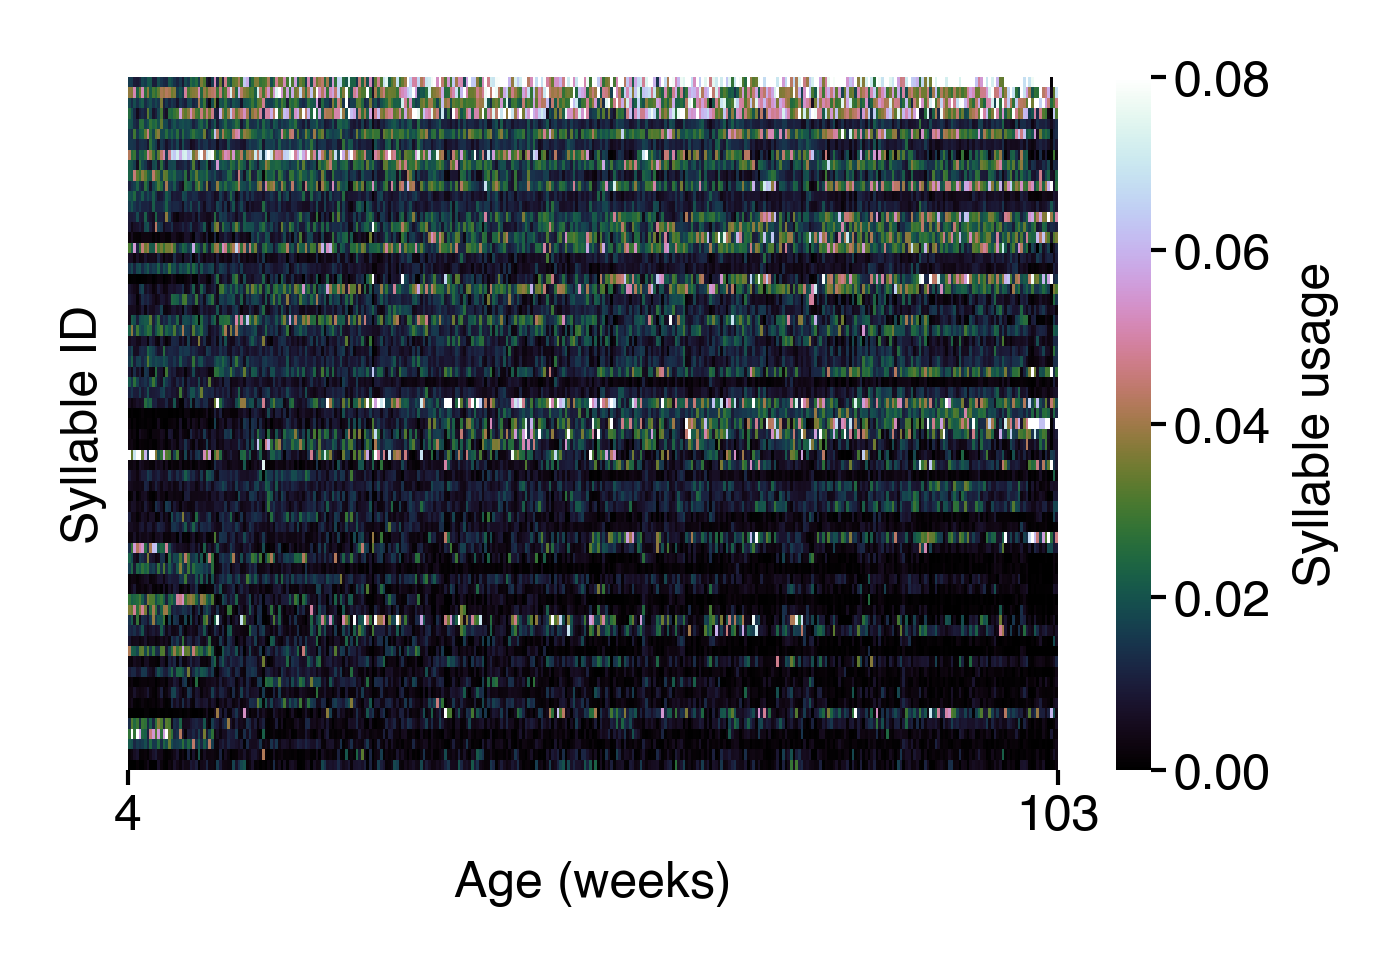

In [7]:
age = usage_mtx.index.get_level_values('age')
fig = figure(2.5, 1.5)
ax = sns.heatmap(usage_mtx[keep_sylls].T, vmax=0.08, cmap="cubehelix", cbar_kws={'label': 'Syllable usage'})
ax.set(xticks=[0, len(usage_mtx)], xticklabels=[age.min(), age.max()], xlabel='Age (weeks)', yticks=[], ylabel='Syllable ID',)
plt.xticks(rotation=0)
saver(fig, "ontogeny-males-usage-heatmap");

In [6]:
from sklearn.decomposition import PCA

In [7]:
latents = PCA(n_components=2).fit_transform(usage_mtx[keep_sylls])

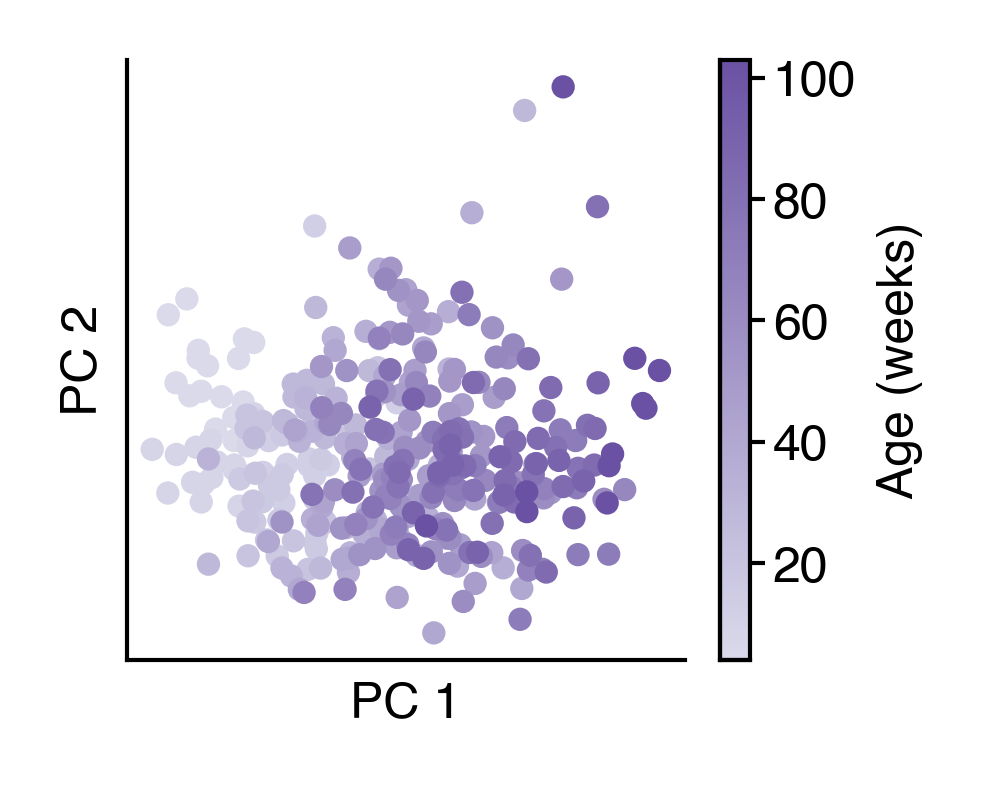

In [10]:
fig = figure(1.5, 1.3)
ax = fig.gca()
im = ax.scatter(*latents.T, c=usage_mtx.index.get_level_values('age'), cmap=ONTOGENY_AGE_CMAP, s=4)
ax.set(xlabel='PC 1', ylabel='PC 2', xticks=[], yticks=[])
fig.colorbar(im, label="Age (weeks)")
sns.despine()
saver(fig, 'pca-usage-ontogeny-males');

In [8]:
corr = pd.DataFrame({'pc1': latents[:, 0], 'age': usage_mtx.index.get_level_values('age')}).corr(method='spearman').loc['pc1', 'age']

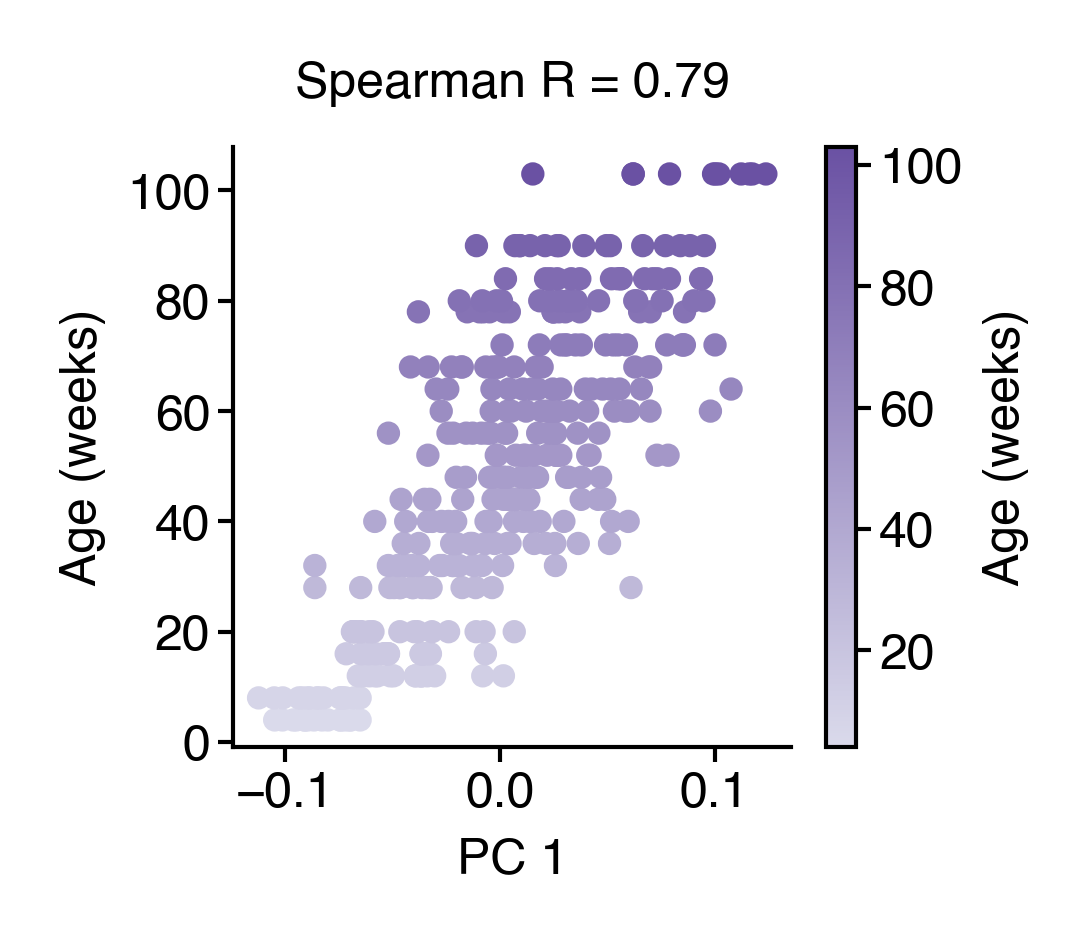

In [12]:
fig = figure(1.5, 1.3)
ax = fig.gca()
im = ax.scatter(latents[:, 0], usage_mtx.index.get_level_values('age'), c=usage_mtx.index.get_level_values('age'), cmap=ONTOGENY_AGE_CMAP, s=4)
sns.despine()
ax.set(xlabel='PC 1', ylabel='Age (weeks)', title=f'Spearman R = {corr:.2f}')
fig.colorbar(im, label="Age (weeks)")
saver(fig, 'pc-vs-age-ontogeny-males');

In [9]:
pca = PCA().fit(usage_mtx[keep_sylls])

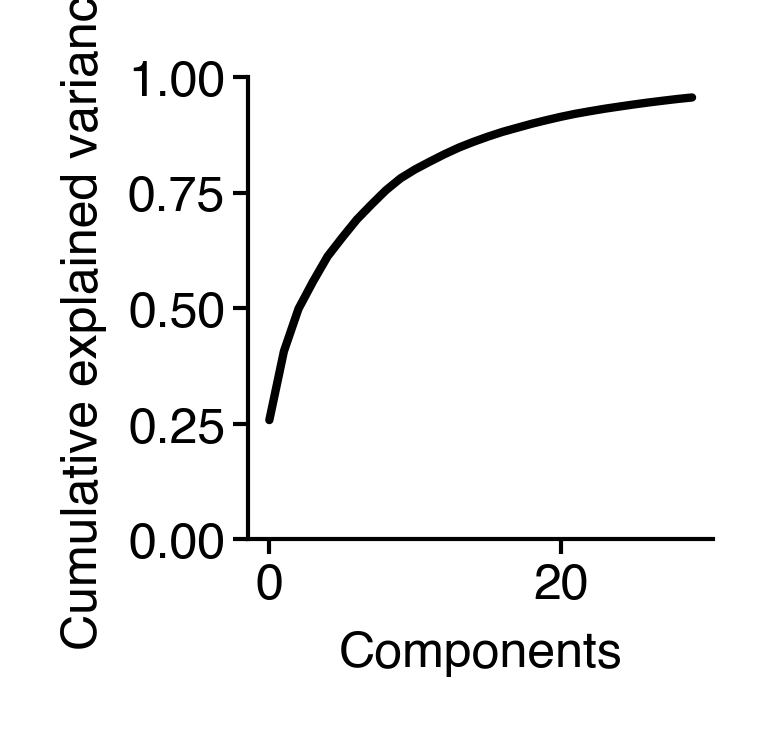

In [14]:
fig = figure(1, 1)
ax = fig.gca()
ax.plot(np.cumsum(pca.explained_variance_ratio_)[:30], color='k')
ax.set(xlabel='Components', ylabel='Cumulative explained variance', ylim=(0, 1))
sns.despine()
saver(fig, 'pca-cumulative-variance');

In [10]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut, GridSearchCV, GroupKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge

In [11]:
y = usage_mtx.index.get_level_values('age')
# x = pd.concat([usage_mtx[keep_sylls], np.log(usage_mtx[keep_sylls] + 1e-6)], axis=1)
x = usage_mtx[keep_sylls]

In [12]:
pipeline = make_pipeline(StandardScaler(), PCA(), KernelRidge(kernel='poly', alpha=0.63, degree=3, gamma=0.01))

In [18]:
cv = GridSearchCV(
    pipeline,
    param_grid={
        "pca__n_components": range(2, 25),
        "kernelridge__alpha": np.logspace(-2, 2, 21),
        "kernelridge__gamma": np.logspace(-3, 1, 21),
        "kernelridge__degree": range(2, 4),
        "kernelridge__kernel": ["poly", "rbf"],
    },
    cv=GroupKFold(n_splits=4),
    n_jobs=-1,
)

cv.fit(x, y, groups=y)

In [19]:
cv.best_params_

{'kernelridge__alpha': 0.01,
 'kernelridge__degree': 2,
 'kernelridge__gamma': 0.001584893192461114,
 'kernelridge__kernel': 'rbf',
 'pca__n_components': 20}

In [20]:
cv.best_score_

0.6799969072846754

In [21]:
pipeline = make_pipeline(StandardScaler(), KernelRidge(kernel='poly', alpha=0.63, degree=3, gamma=0.01))
# pipeline = make_pipeline(StandardScaler(), PLSRegression(n_components=5))
preds = cross_val_predict(pipeline, x, y, groups=y, cv=LeaveOneGroupOut(), n_jobs=-1)
r2_score(y, preds)

0.7131621591202084

In [22]:
preds = cross_val_predict(cv.best_estimator_, x, y, groups=y, cv=LeaveOneGroupOut(), n_jobs=-1)
r2_score(y, preds)

0.7182484916033002

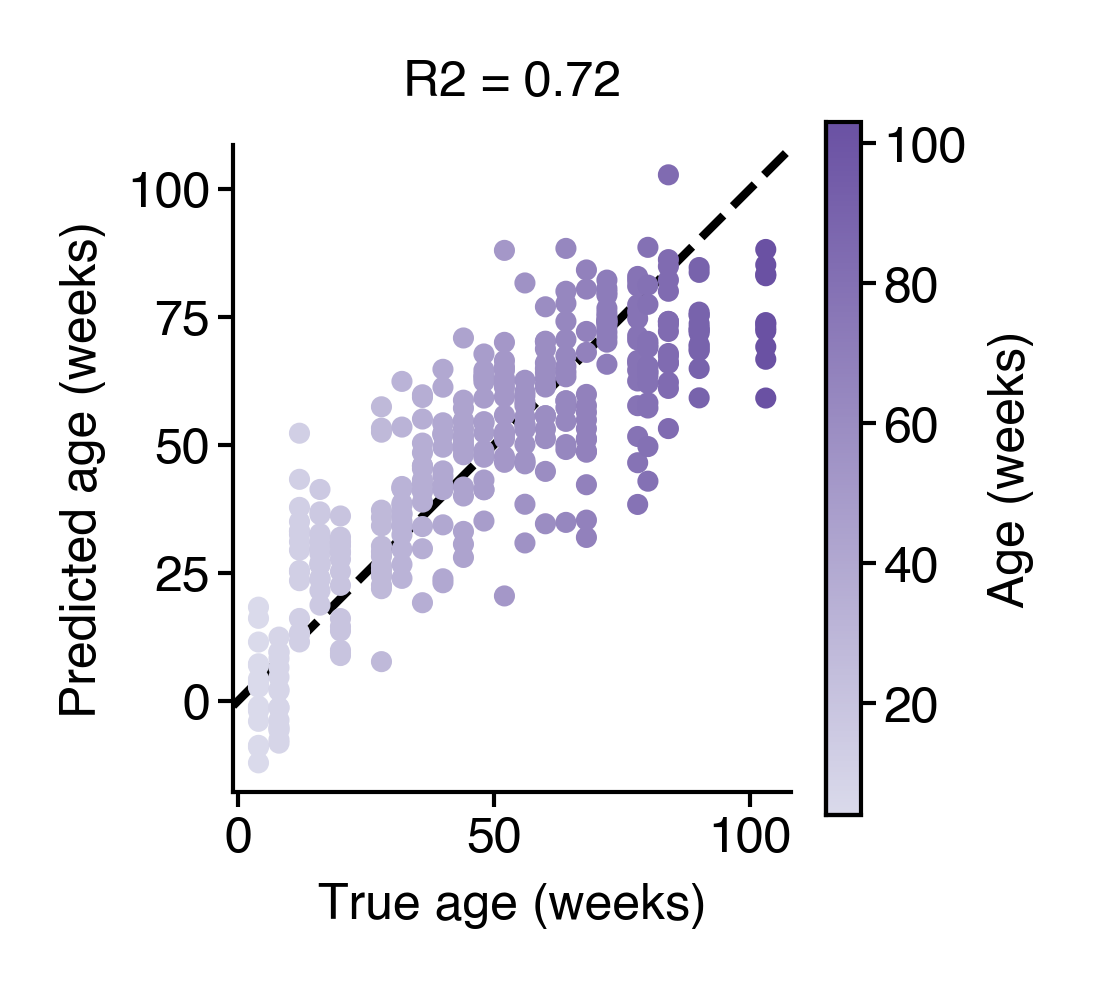

In [23]:
fig = figure(1.5, 1.5)
ax = fig.gca()
im = ax.scatter(y, preds, c=y, cmap=ONTOGENY_AGE_CMAP, s=3)
add_identity(ax, ls='--', color='k', zorder=-1)
fig.colorbar(im, label="Age (weeks)")
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)', title=f'R2 = {r2_score(y, preds):.2f}', aspect='equal')
sns.despine()
saver(fig, 'ontogeny-age-regression');

In [24]:
residuals = pd.Series(y - preds, index=usage_mtx.index)

Text(0, 0.5, 'Residuals (weeks)')

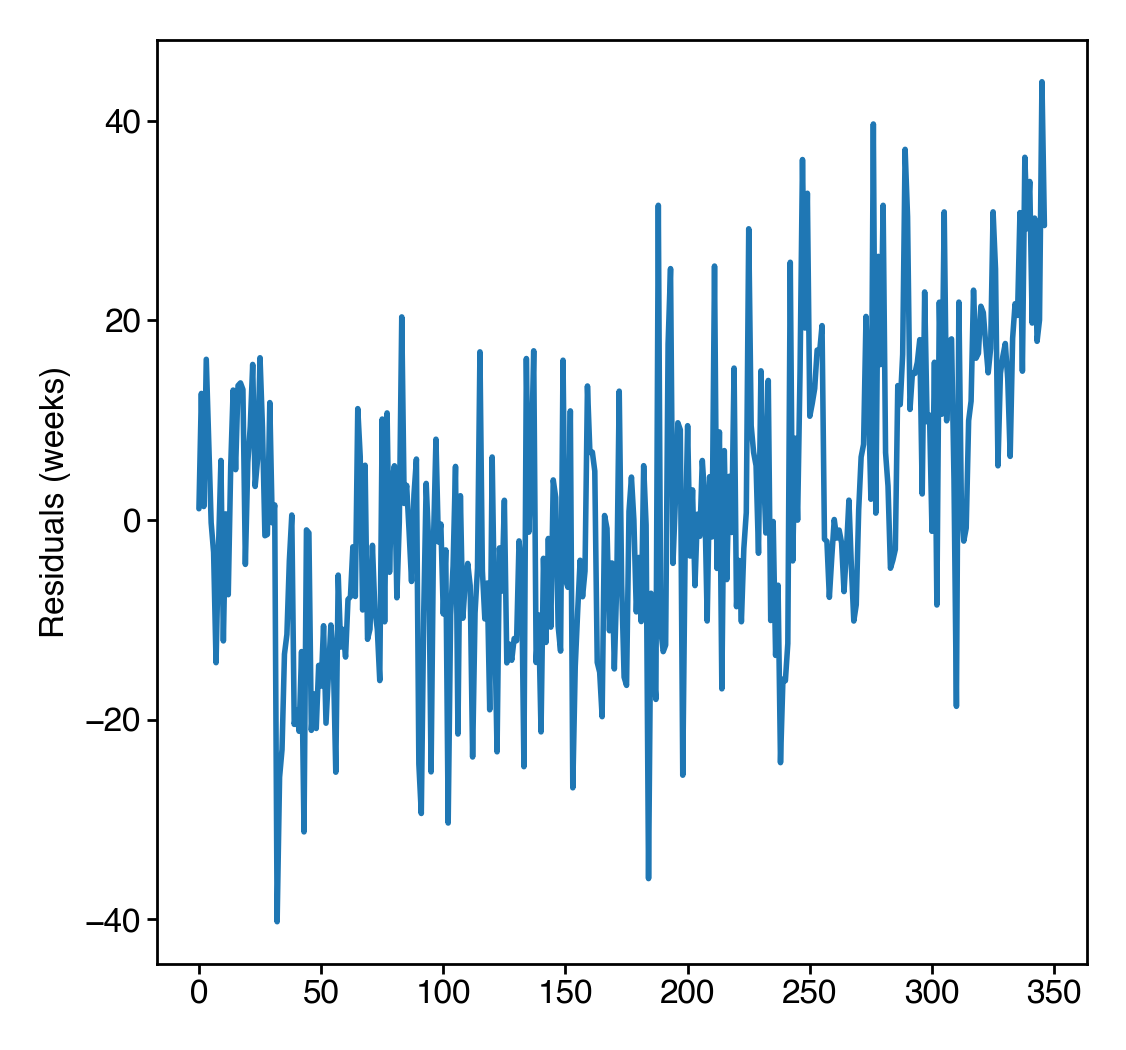

In [25]:
plt.plot(residuals.values)
plt.ylabel('Residuals (weeks)')

## Pseudotime

In [13]:
from aging.behavior.pseudotime import compute_pseudotime, pseudotime_springplot
from scipy.spatial.distance import pdist, squareform

  0%|          | 0/5000 [00:00<?, ?it/s]

pseudotime_rank       age
pseudotime_rank         1.000000  0.800464
age                     0.800464  1.000000

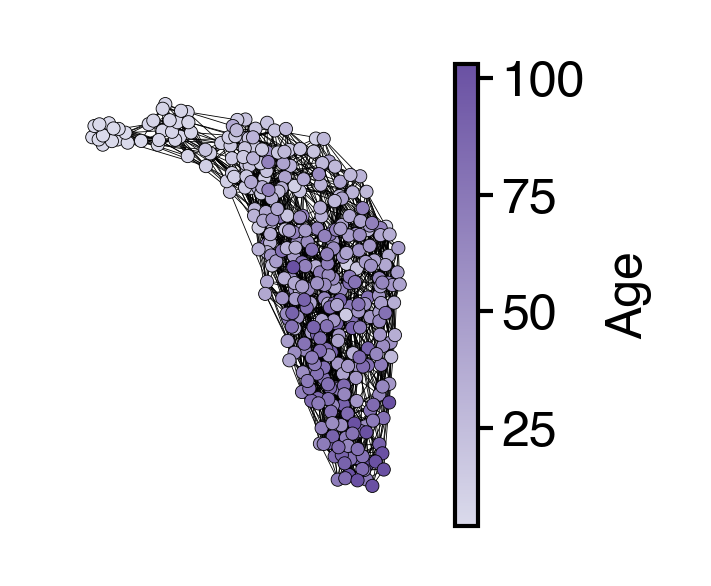

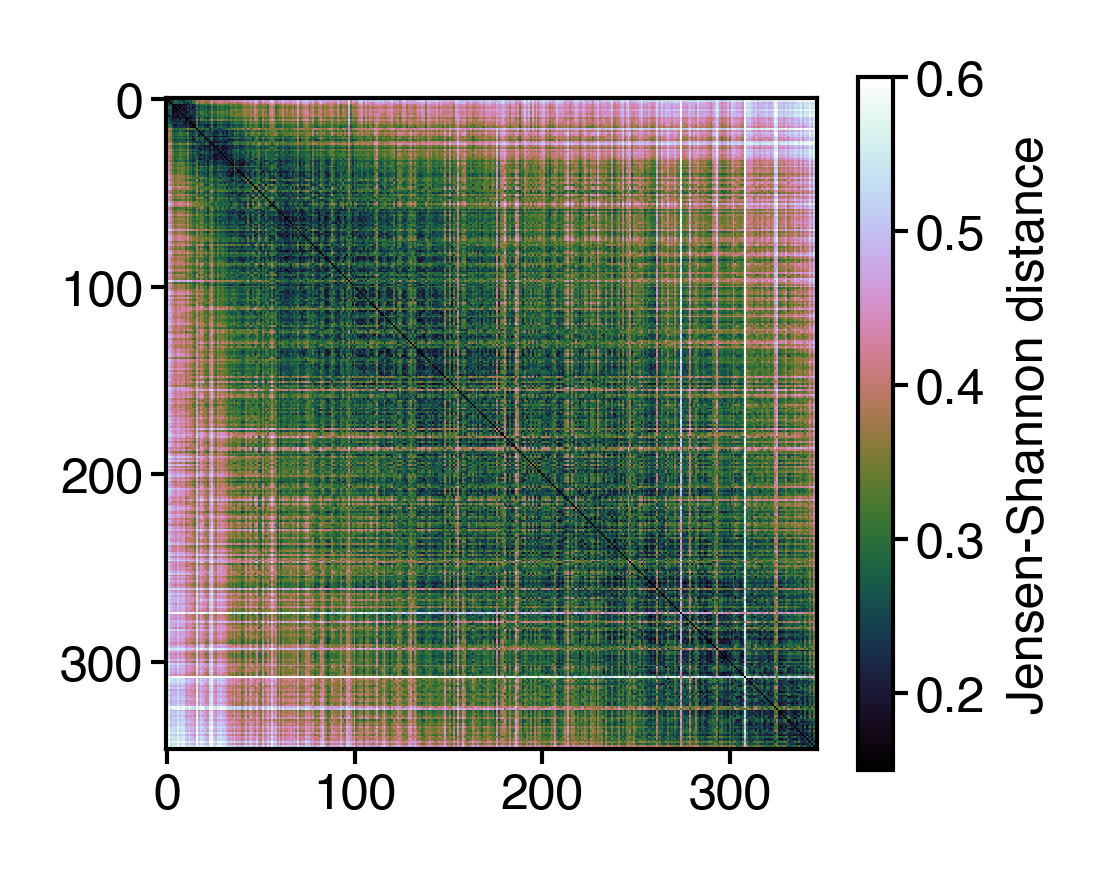

In [14]:
params = {
    "metric": "jensenshannon",
    "k_neigh": 10,
}
pseudo_df = compute_pseudotime(
    usage_mtx[keep_sylls], **params, initialize_w_age=True,
)

graph, pos, c, fig = pseudotime_springplot(
    usage_mtx[keep_sylls],
    **params,
    seed=1,
    node_size=2.5,
    cmap=ONTOGENY_AGE_CMAP,
)
saver(fig, "pseudotime-ontogeny-male-spring");

fig = figure(1.75, 1.5)
d = squareform(
        pdist(
            usage_mtx[keep_sylls].iloc[np.argsort(pseudo_df.pseudotime_rank.values)],
            metric="jensenshannon",
        )
    )
plt.imshow(
    d,
    vmin=0.15,
    vmax=0.6,
    cmap="cubehelix",
    interpolation="none",
)
plt.colorbar(label="Jensen-Shannon distance")
saver(fig, "pseudotime-distance-matrix-ontogeny-male")

pseudo_df.reset_index().loc[:, ["pseudotime_rank", "age"]].corr(method="spearman")

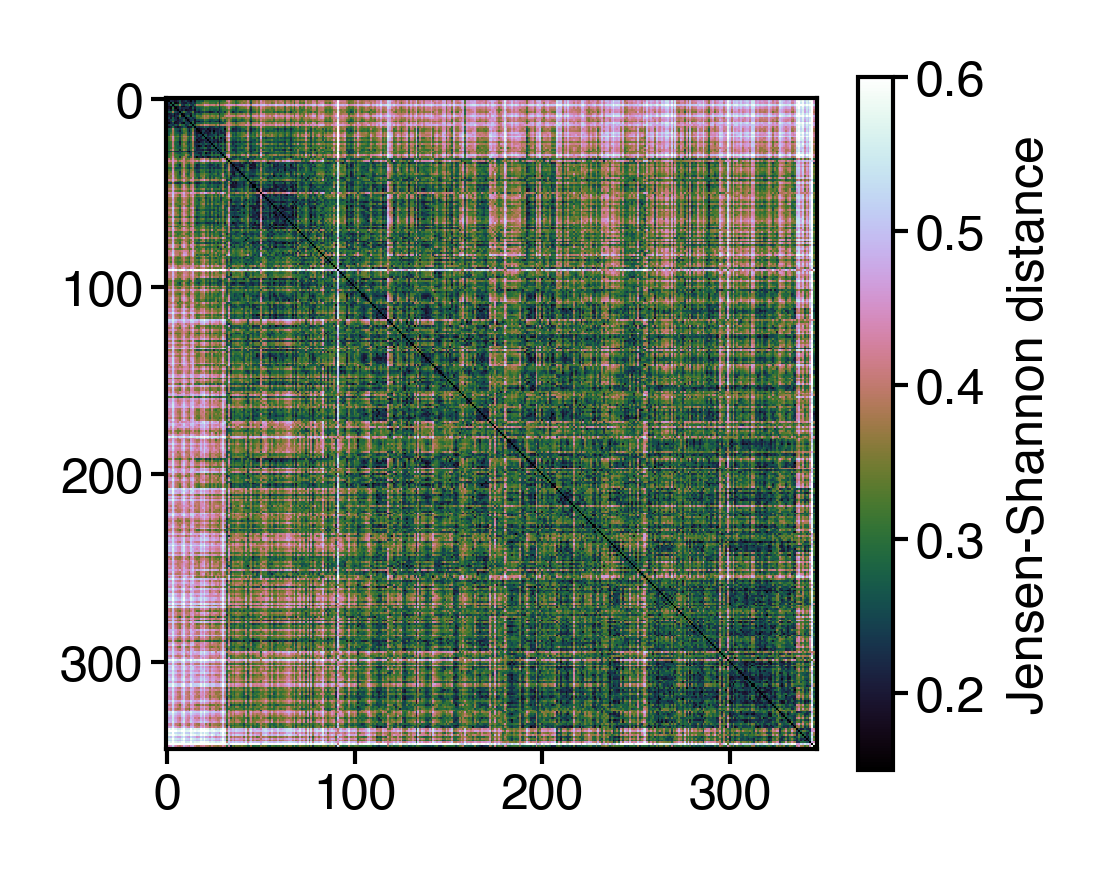

In [28]:
fig = figure(1.75, 1.5)
d = squareform(
        pdist(
            usage_mtx[keep_sylls],
            metric="jensenshannon",
        )
    )
plt.imshow(
    d,
    vmin=0.15,
    vmax=0.6,
    cmap="cubehelix",
    interpolation="none",
)
plt.colorbar(label="Jensen-Shannon distance")
saver(fig, "age-distance-matrix-ontogeny-male");

In [15]:
all_ages = usage_mtx.index.get_level_values('age').value_counts().sort_index()

In [16]:
all_ages

age
4      16
8      16
12     16
16     16
20     16
28     16
32     16
36     16
40     16
44     16
48     16
52     16
56     16
60     16
64     16
68     16
72     16
78     16
80     16
84     16
90     16
103    11
Name: count, dtype: int64

In [17]:
from toolz import concat

In [18]:
merged_df = usage_mtx.join(pseudo_df)
merged_df = merged_df.sort_values(by='pseudotime_rank')
merged_df['pseudo_age'] = list(concat([x] * v for x, v in all_ages.items()))
merged_df.set_index(['pseudotime_rank', 'pseudotime_dist', 'pseudo_age'], append=True, inplace=True)

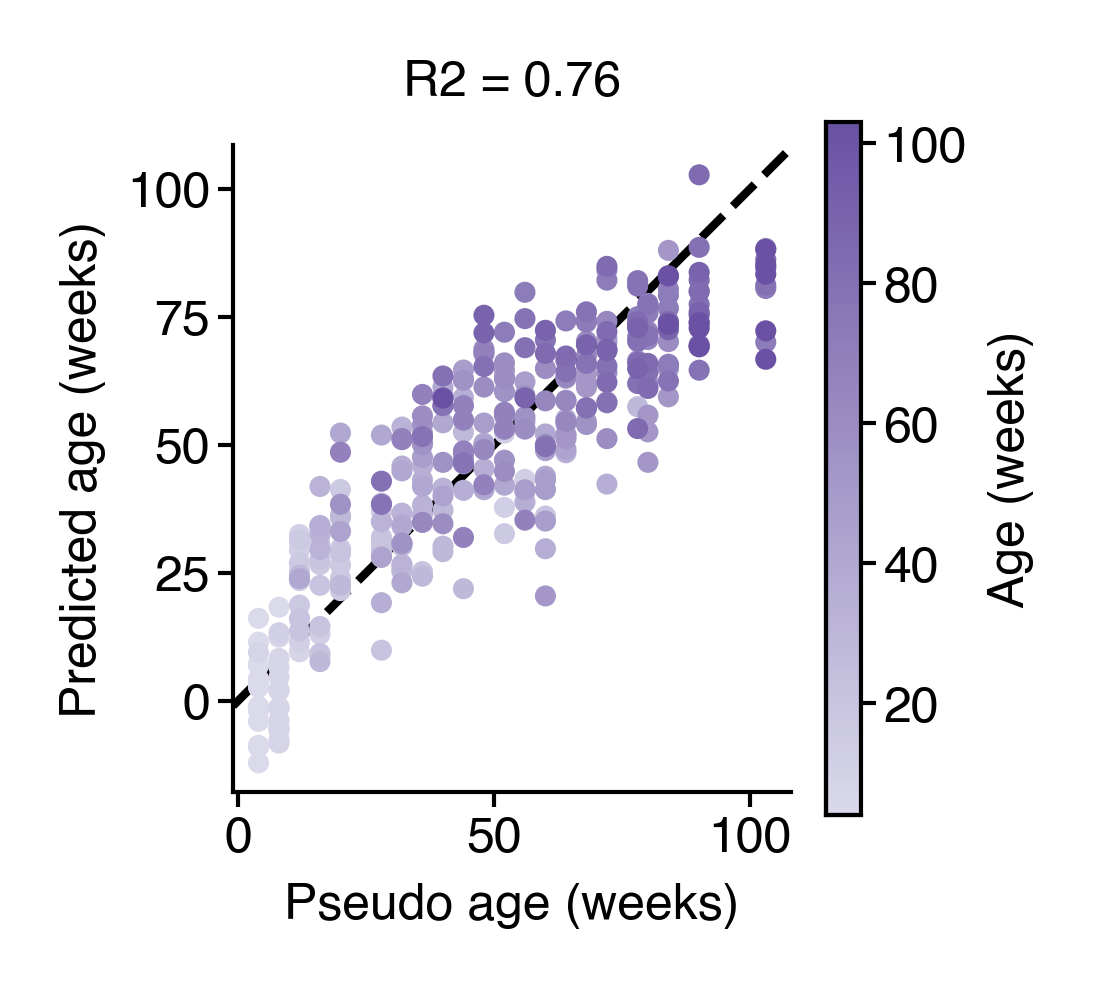

In [33]:
pseudo_y = merged_df.sort_index(level='age').index.get_level_values('pseudo_age')
fig = figure(1.5, 1.5)
ax = fig.gca()
im = ax.scatter(pseudo_y, preds, c=y, cmap=ONTOGENY_AGE_CMAP, s=3)
add_identity(ax, ls='--', color='k', zorder=-1)
fig.colorbar(im, label="Age (weeks)")
ax.set(xlabel='Pseudo age (weeks)', ylabel='Predicted age (weeks)', title=f'R2 = {r2_score(pseudo_y, preds):.2f}', aspect='equal')
sns.despine()
saver(fig, 'ontogeny-age-regression-pseudo-age');

In [34]:
pseudo_residuals = pd.Series(merged_df.index.get_level_values('age') - merged_df.index.get_level_values('pseudo_age'), index=merged_df.index)

In [35]:
pr = pseudo_residuals.droplevel(['pseudotime_rank', 'pseudotime_dist', 'pseudo_age'])

In [36]:
r = residuals.corr(pr, method='spearman')

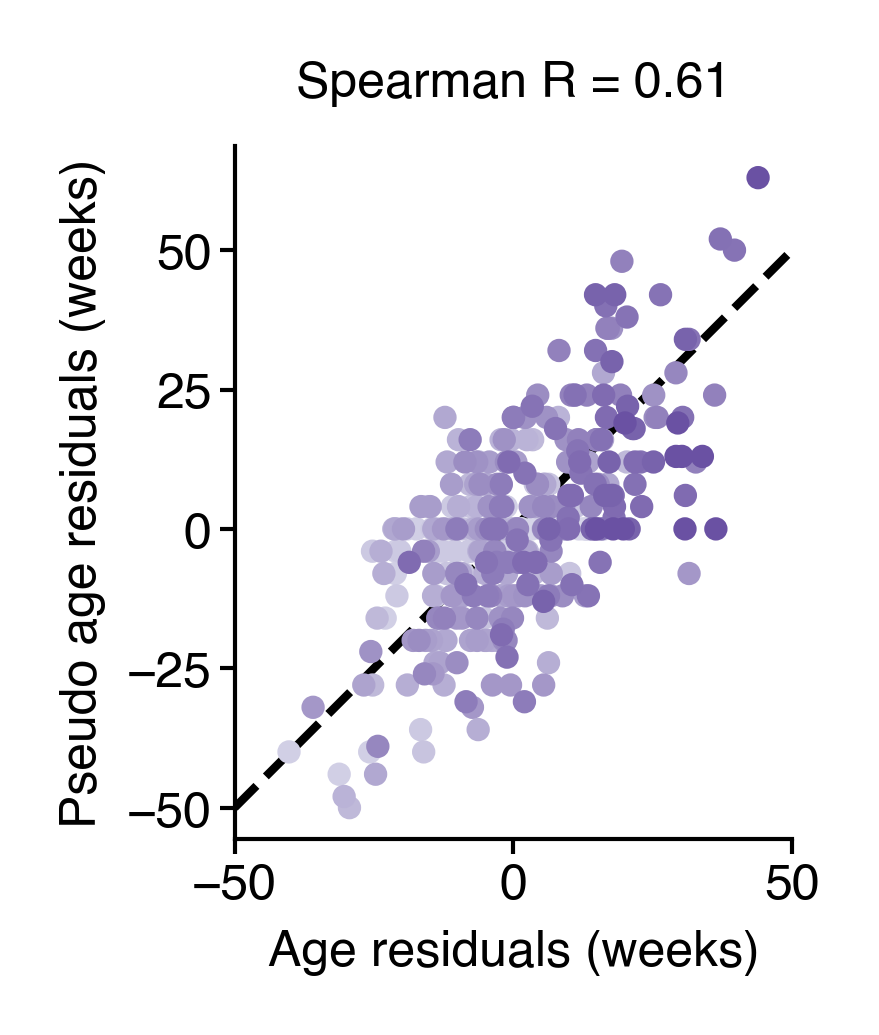

In [37]:
fig = figure(1.5, 1.5)
ax = fig.gca()
ax.scatter(residuals, pr.loc[residuals.index], s=4, c=residuals.index.get_level_values('age'), cmap=ONTOGENY_AGE_CMAP)
add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlabel="Age residuals (weeks)", ylabel="Pseudo age residuals (weeks)", aspect='equal', xlim=(-50, 50), title=f"Spearman R = {r:.2f}")
sns.despine()
saver(fig, 'residuals-vs-pseudo-residuals-ontogeny-male');

In [38]:
pseudo_y = merged_df.index.get_level_values('pseudo_age')
x = merged_df[keep_sylls]

In [39]:
pipeline = make_pipeline(StandardScaler(), PCA(), KernelRidge(kernel='poly', alpha=0.63, degree=3, gamma=0.01))

In [40]:
cv = GridSearchCV(
    pipeline,
    param_grid={
        "pca__n_components": range(2, 25),
        "kernelridge__alpha": np.logspace(-2, 2, 21),
        "kernelridge__gamma": np.logspace(-3, 1, 21),
        "kernelridge__degree": range(2, 4),
        "kernelridge__kernel": ["poly", "rbf"],
    },
    cv=GroupKFold(n_splits=4),
    n_jobs=-1,
)

cv.fit(x, pseudo_y, groups=pseudo_y)

GridSearchCV(cv=GroupKFold(n_splits=4),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('kernelridge',
                                        KernelRidge(alpha=0.63, gamma=0.01,
                                                    kernel='poly'))]),
             n_jobs=-1,
             param_grid={'kernelridge__alpha': array([1.00000000e-02, 1.58489319e-02, 2.51188643e-02, 3.98107171e-02,
       6.30957344e-02, 1.00000000e-01, 1.58489319e-01, 2.51188643e-0...
                         'kernelridge__gamma': array([1.00000000e-03, 1.58489319e-03, 2.51188643e-03, 3.98107171e-03,
       6.30957344e-03, 1.00000000e-02, 1.58489319e-02, 2.51188643e-02,
       3.98107171e-02, 6.30957344e-02, 1.00000000e-01, 1.58489319e-01,
       2.51188643e-01, 3.98107171e-01, 6.30957344e-01, 1.00000000e+00,
       1.58489319e+00, 2.51188643e+00, 3.98107171e+00, 6.30957344e+00,
       1.00000000e+01]),
                         'kernelridge__kernel': ['poly', 'rbf'],
                         'pca__n_components': range(2, 25)})

In [41]:
cv.best_params_

{'kernelridge__alpha': 0.025118864315095794,
 'kernelridge__degree': 2,
 'kernelridge__gamma': 0.0025118864315095794,
 'kernelridge__kernel': 'rbf',
 'pca__n_components': 17}

In [42]:
preds = cross_val_predict(cv.best_estimator_, x, pseudo_y, groups=pseudo_y, cv=LeaveOneGroupOut(), n_jobs=-1)
r2_score(y, preds)

0.9581027662231909

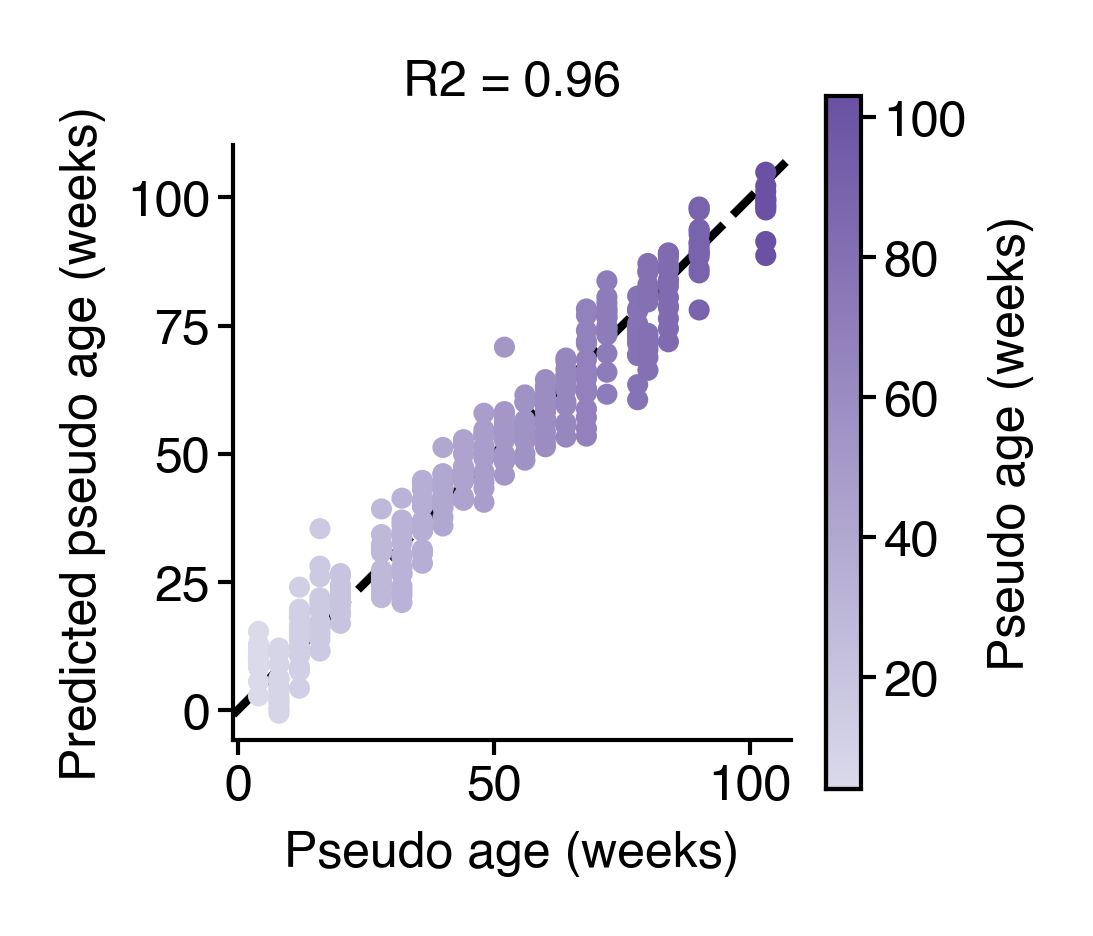

In [43]:
fig = figure(1.5, 1.5)
ax = fig.gca()
im = ax.scatter(pseudo_y, preds, c=pseudo_y, cmap=ONTOGENY_AGE_CMAP, s=3)
add_identity(ax, ls='--', color='k', zorder=-1)
fig.colorbar(im, label="Pseudo age (weeks)")
ax.set(xlabel='Pseudo age (weeks)', ylabel='Predicted pseudo age (weeks)', title=f'R2 = {r2_score(y, preds):.2f}', aspect='equal')
sns.despine()
saver(fig, 'ontogeny-pseudo-age-regression');

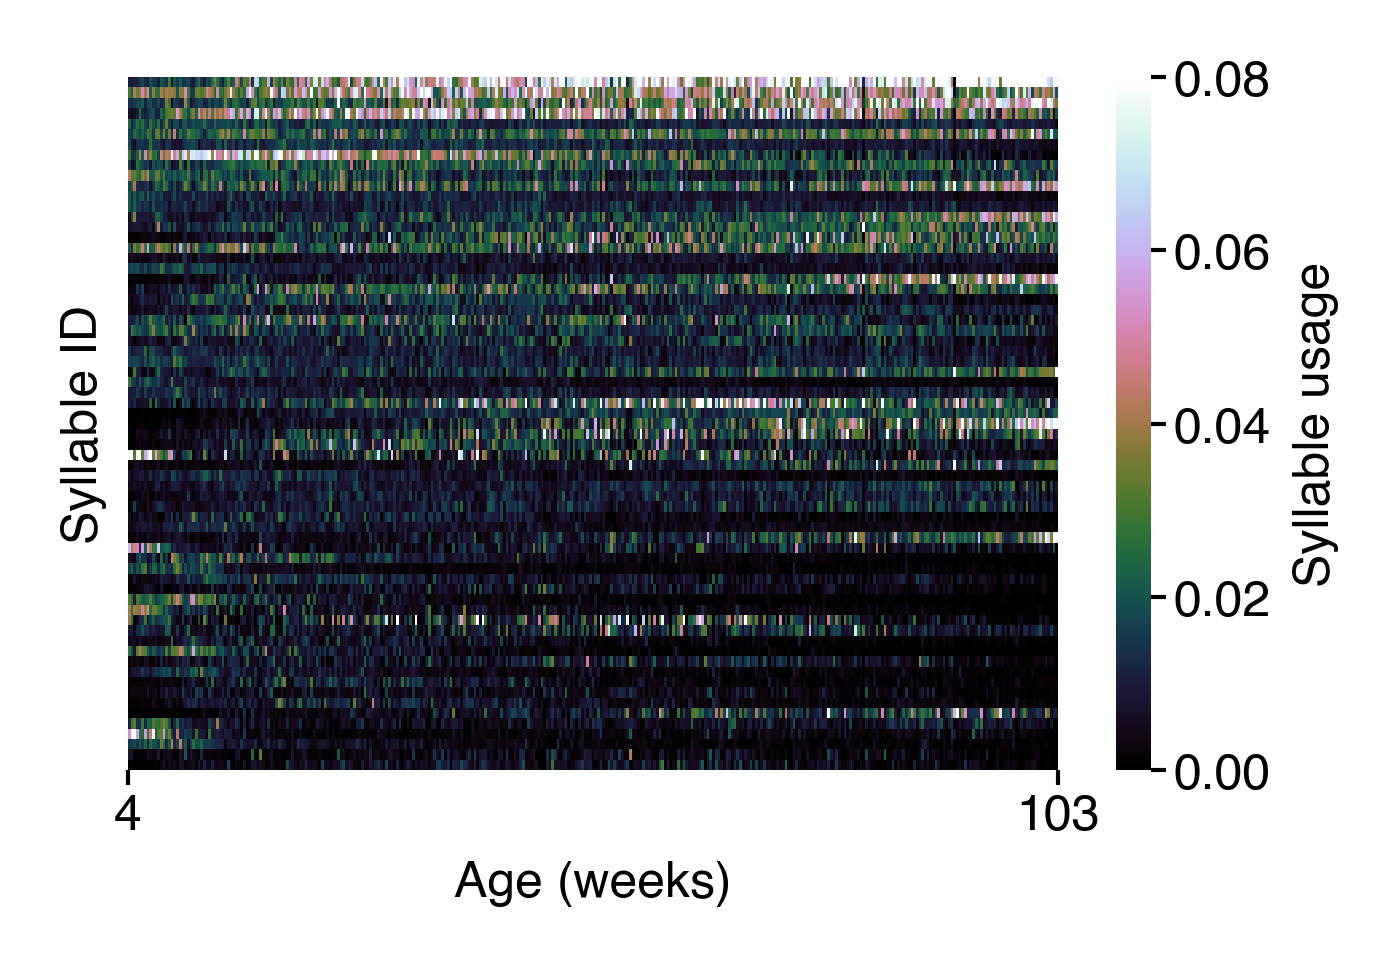

In [44]:
age = merged_df.index.get_level_values('pseudo_age')
fig = figure(2.5, 1.5)
ax = sns.heatmap(merged_df.sort_index(level='pseudotime_rank')[keep_sylls].T, vmax=0.08, cmap="cubehelix", cbar_kws={'label': 'Syllable usage'})
ax.set(xticks=[0, len(merged_df)], xticklabels=[age.min(), age.max()], xlabel='Age (weeks)', yticks=[], ylabel='Syllable ID',)
plt.xticks(rotation=0)
saver(fig, "ontogeny-males-pseudo-age-usage-heatmap");

## Aging dynamics using GP smoothing

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from toolz import valmap, keyfilter

In [20]:
age_scaler = StandardScaler()
x = merged_df.index.get_level_values("pseudo_age")
x = age_scaler.fit_transform(x.to_numpy()[:, None])
time = np.linspace(np.min(x), np.max(x), 300)[:, None]

In [21]:
kernel = 1 * RBF(length_scale=5e2, length_scale_bounds=(1e-3, 1e3))

out = {}
grads = {}

index = pd.Index(age_scaler.inverse_transform(time).squeeze(), name="pseudo_age")

r2_scores = {}

for syll in tqdm(keep_sylls):
    y = merged_df[syll]
    gp = GaussianProcessRegressor(
        kernel=kernel, n_restarts_optimizer=5, alpha=1.125, normalize_y=True
    )
    gp.fit(x, y)
    r2_scores[syll] = gp.score(x, y)
    grads[syll] = np.gradient(gp.predict(time), time.squeeze())
    out[syll] = pd.Series(gp.predict(time), index=index, name="Predicted usage")

  0%|          | 0/67 [00:00<?, ?it/s]

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [22]:
score_thresh = 0.2
# drop_sylls = [29, 47]
drop_sylls = [29, 47, 37, 66, 67]
keep_grads = keyfilter(lambda k: (r2_scores[k] > score_thresh) and (k not in drop_sylls), grads)

<Axes: xlabel='pseudo_age', ylabel='0'>

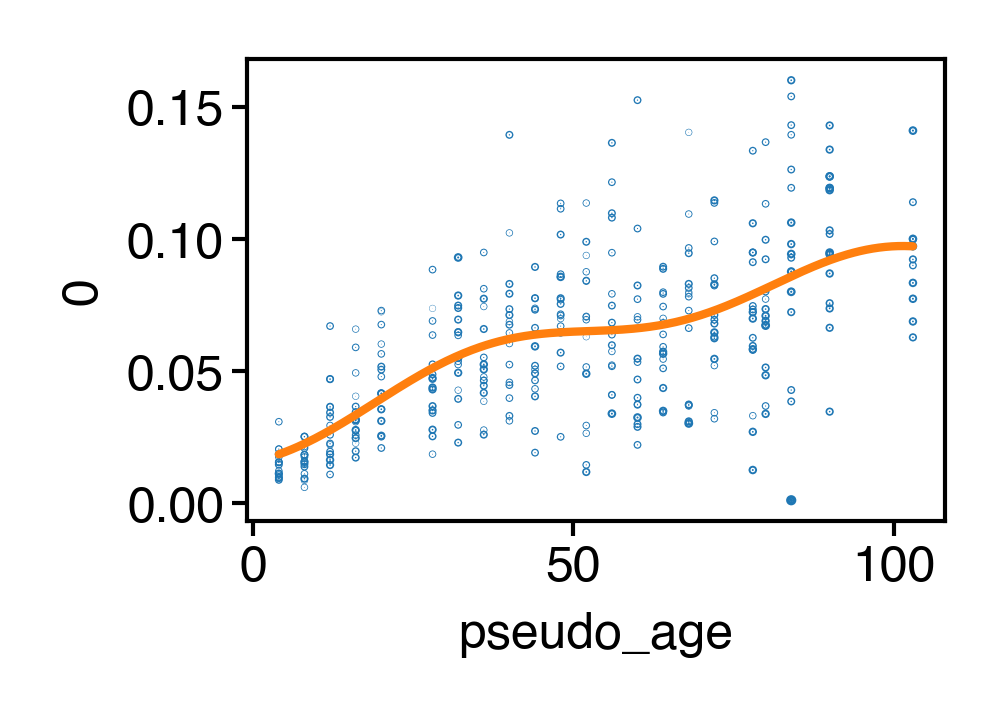

In [23]:
fig = figure(1.5, 1)
ax = fig.gca()
merged_df.reset_index().plot(kind='scatter', y=keep_sylls[0], x='pseudo_age', s=10, ax=ax)
out[keep_sylls[0]].plot(ax=ax, c='C1')

In [208]:
# for k, v in keep_grads.items():
#     v[np.abs(v) > 0.07] = np.mean(v[np.abs(v) < 0.07])

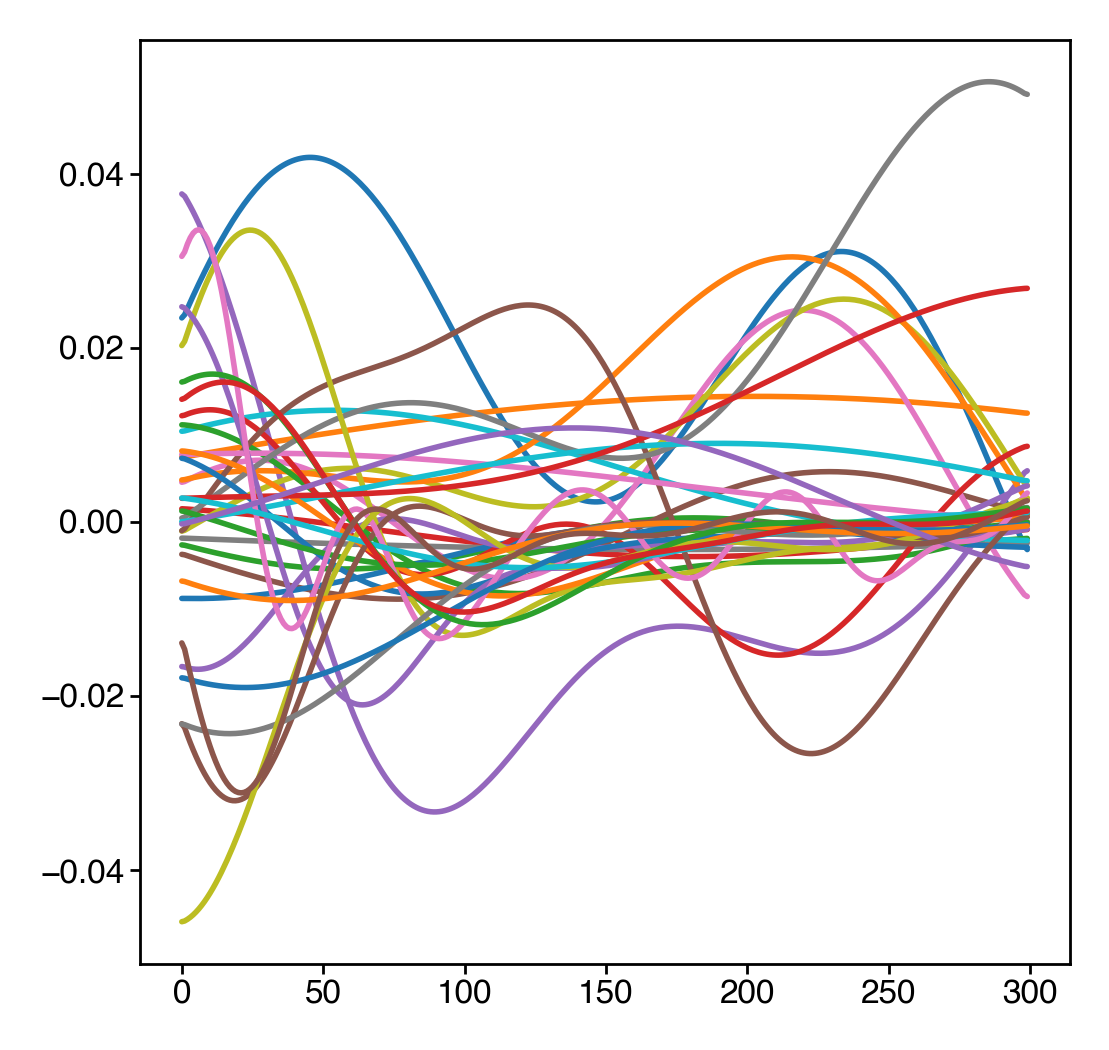

In [24]:
for k, v in keep_grads.items():
    plt.plot(v, label=k)

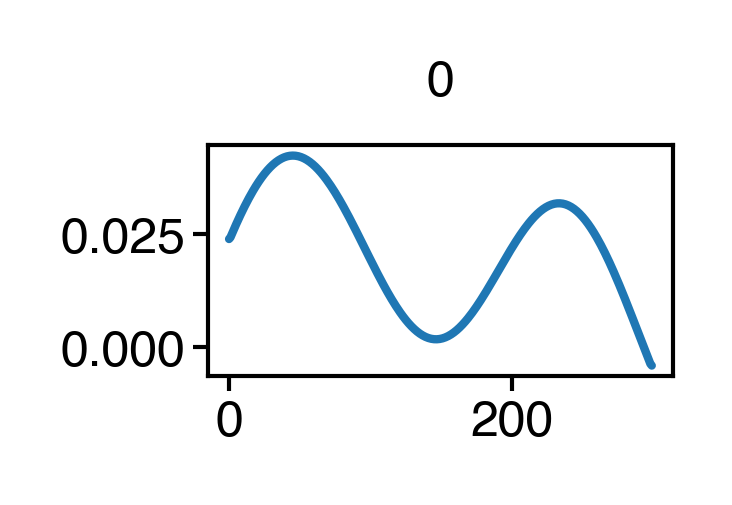

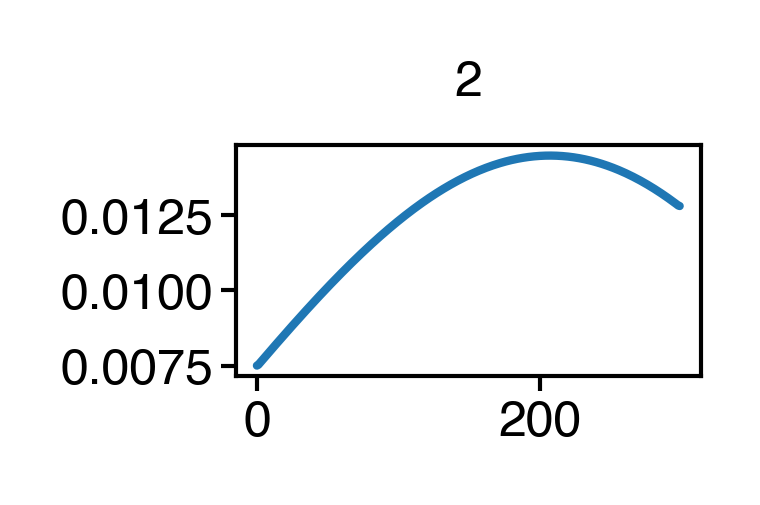

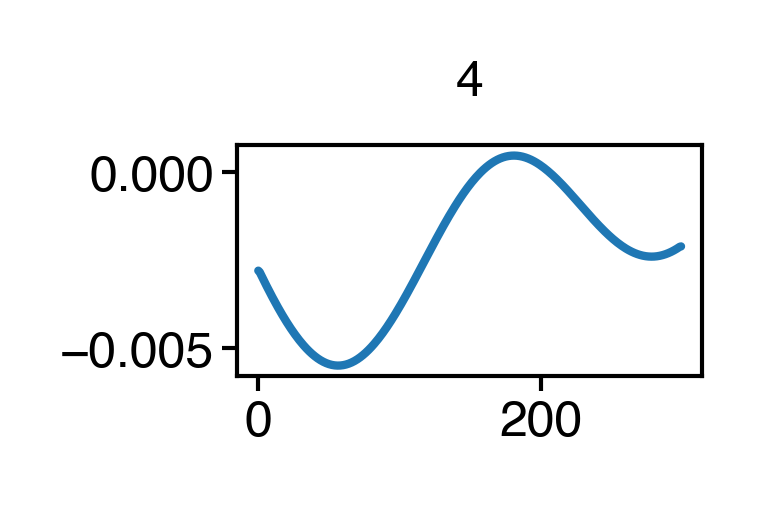

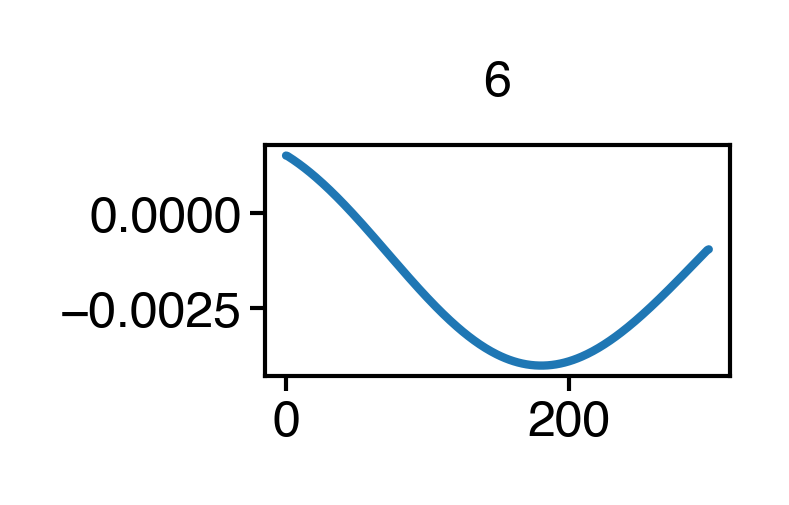

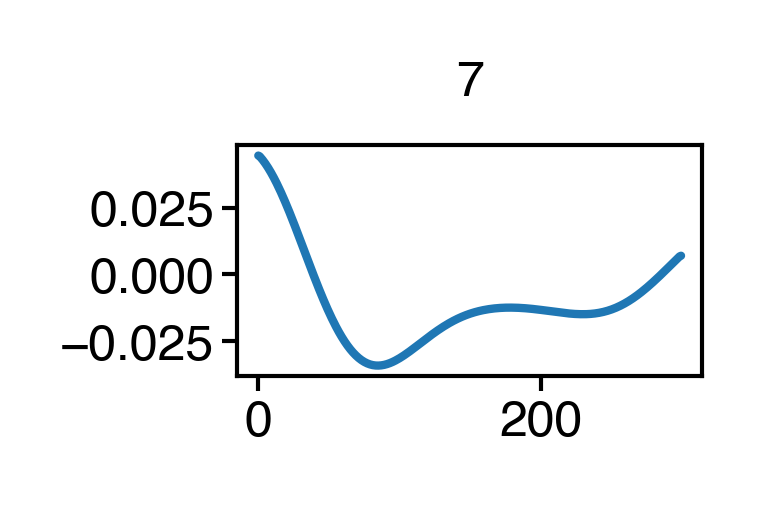

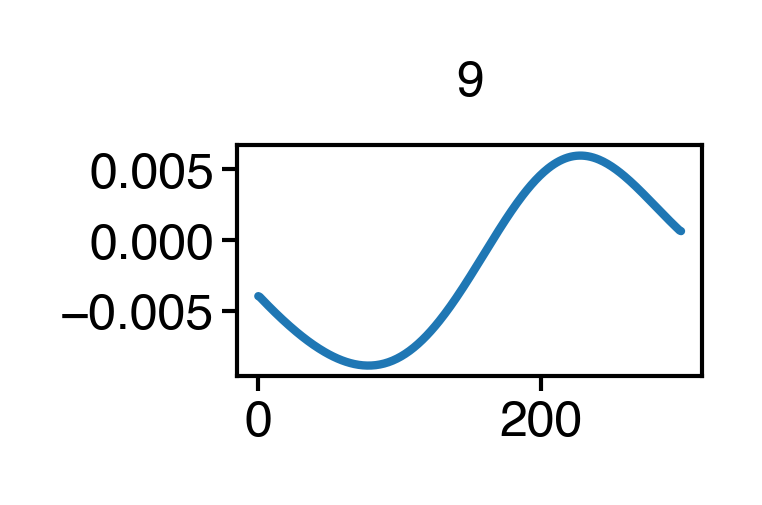

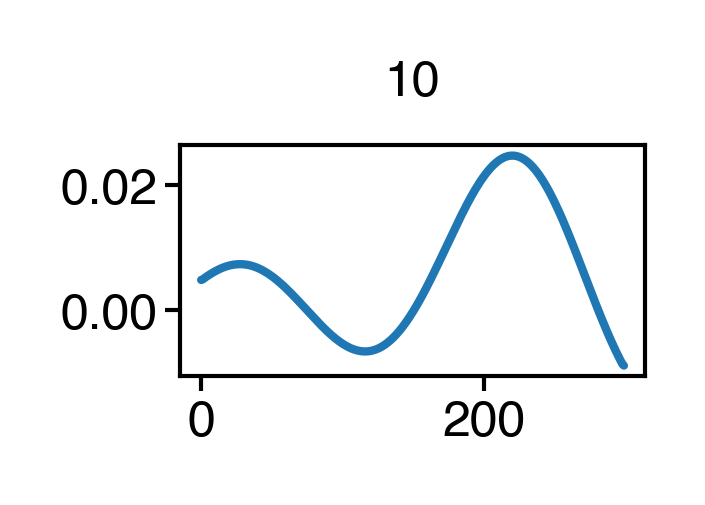

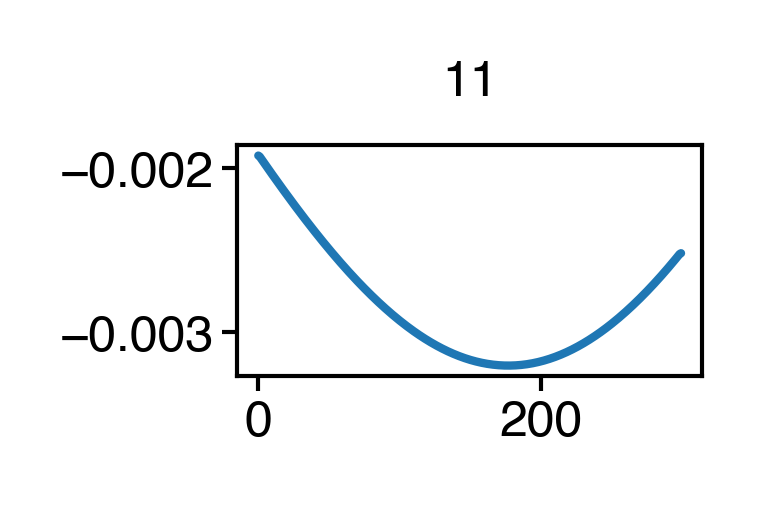

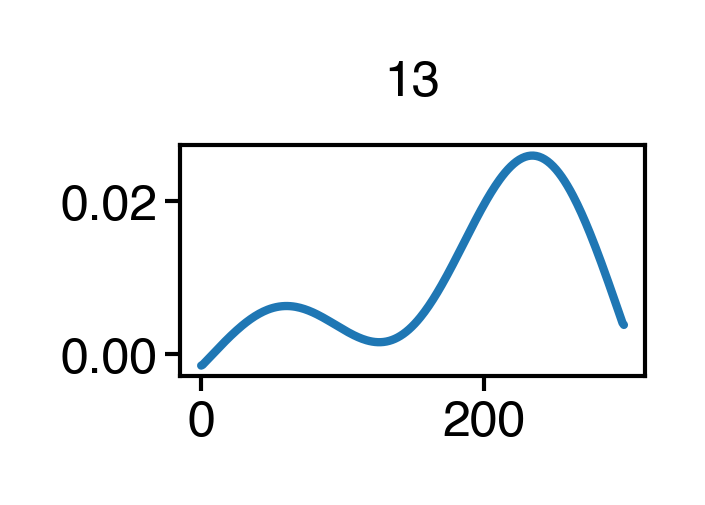

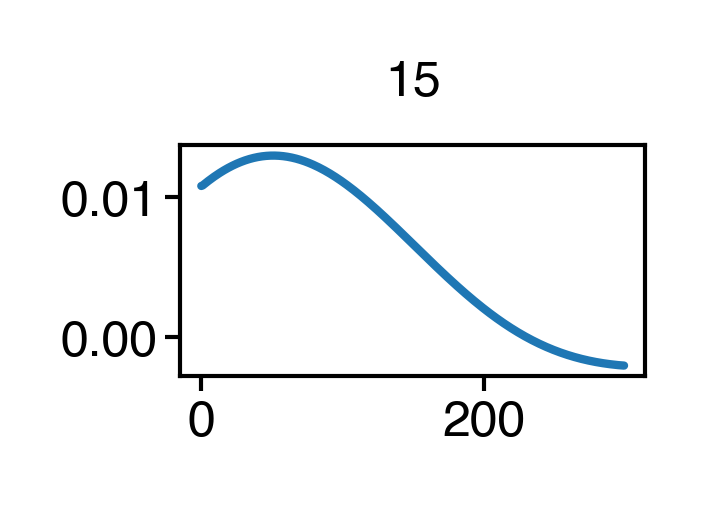

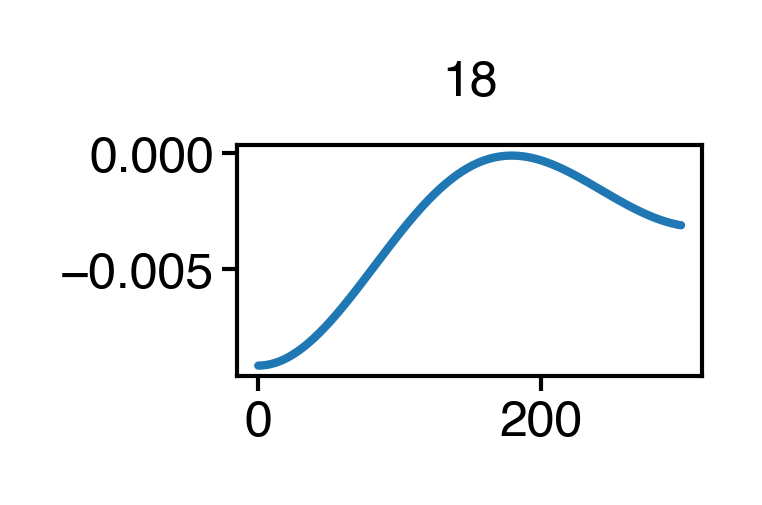

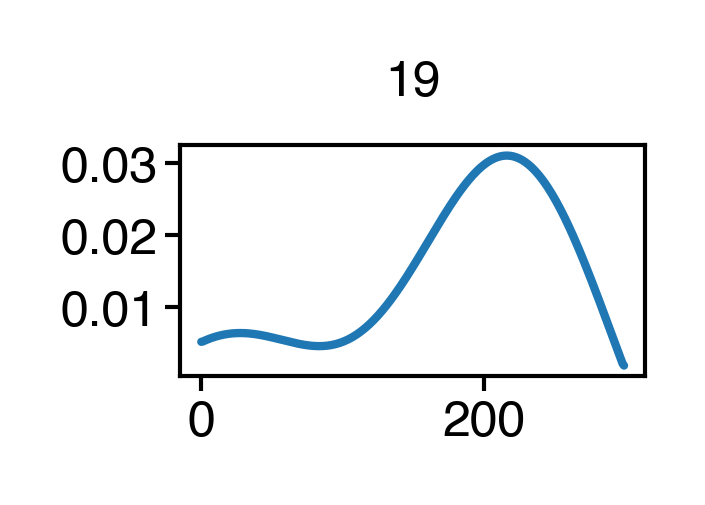

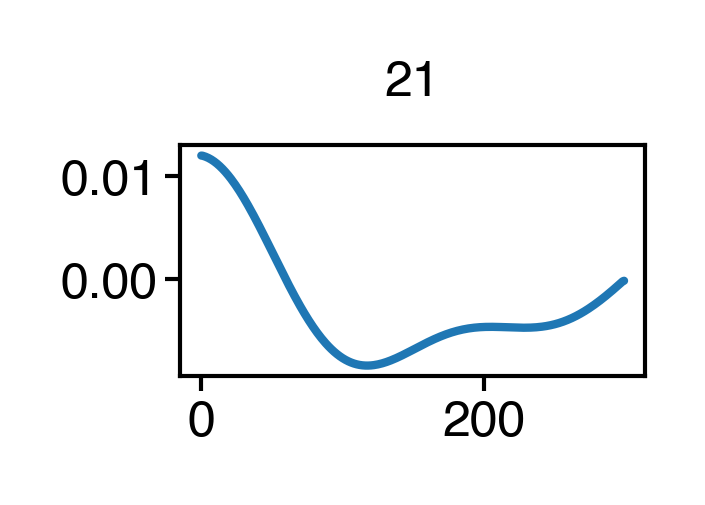

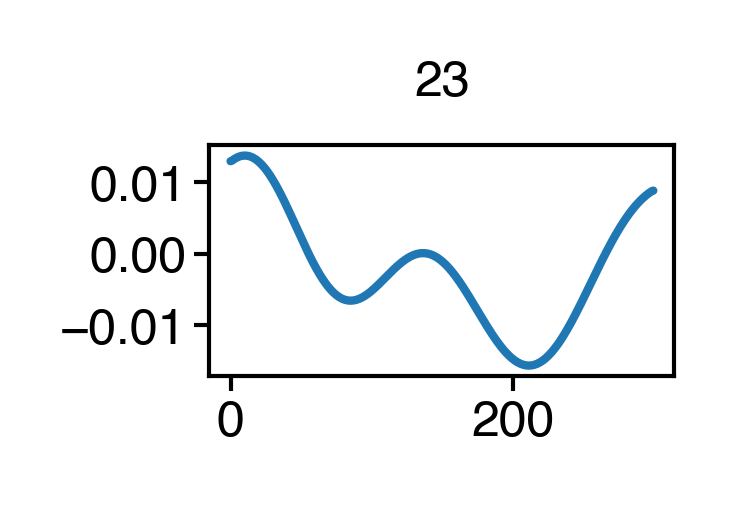

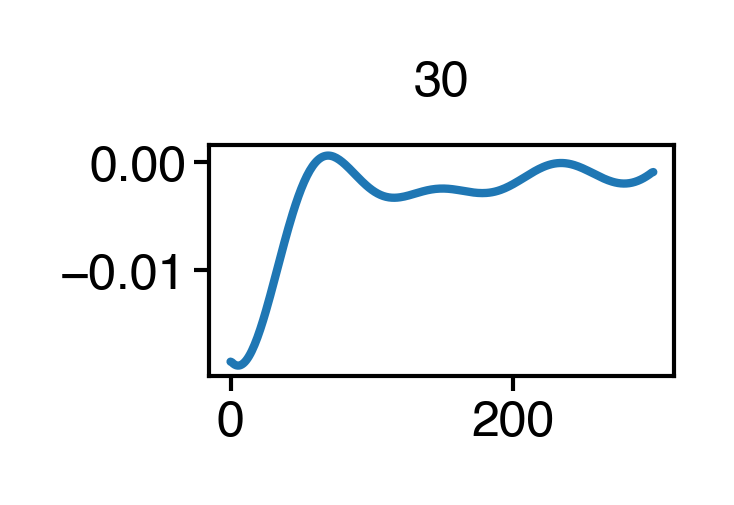

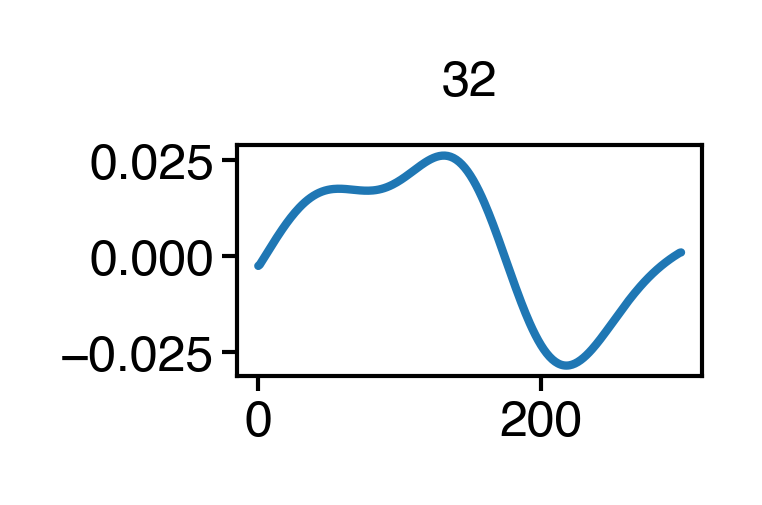

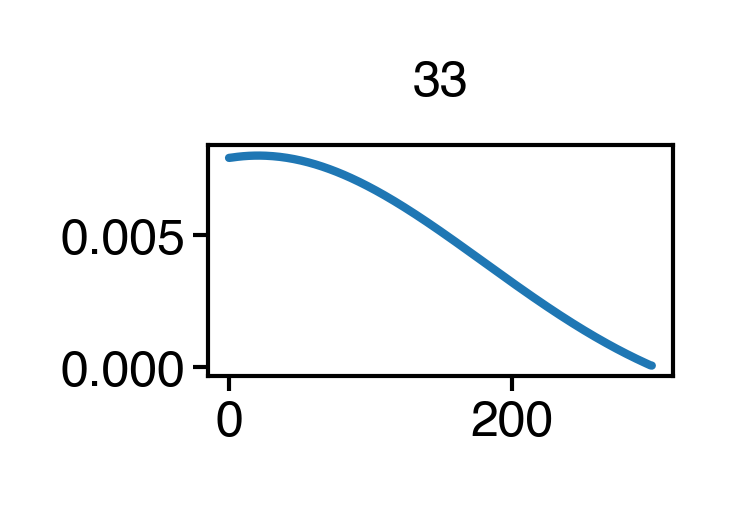

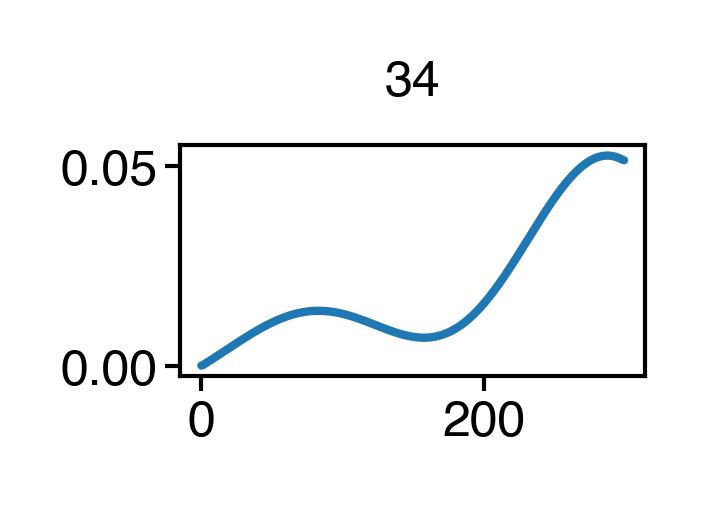

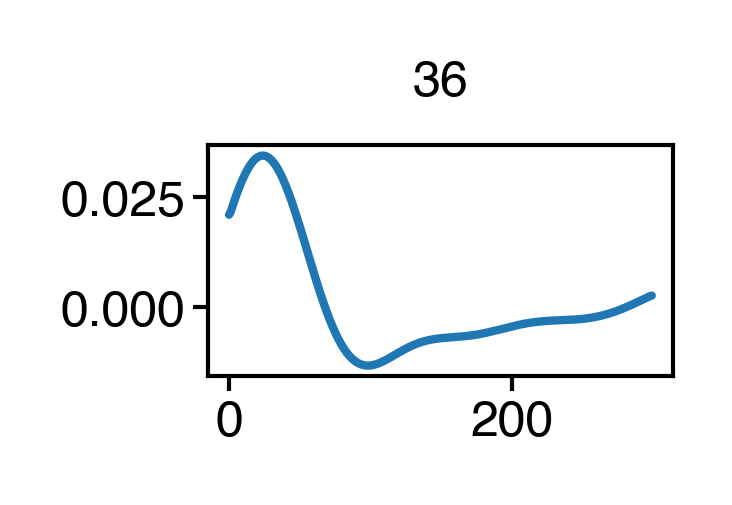

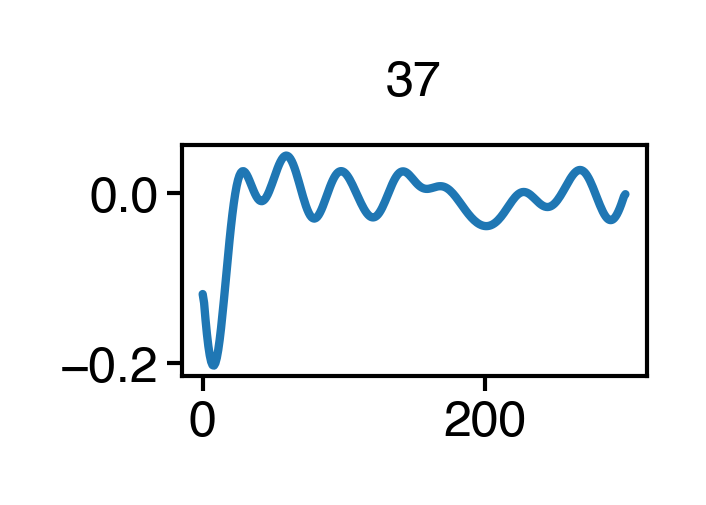

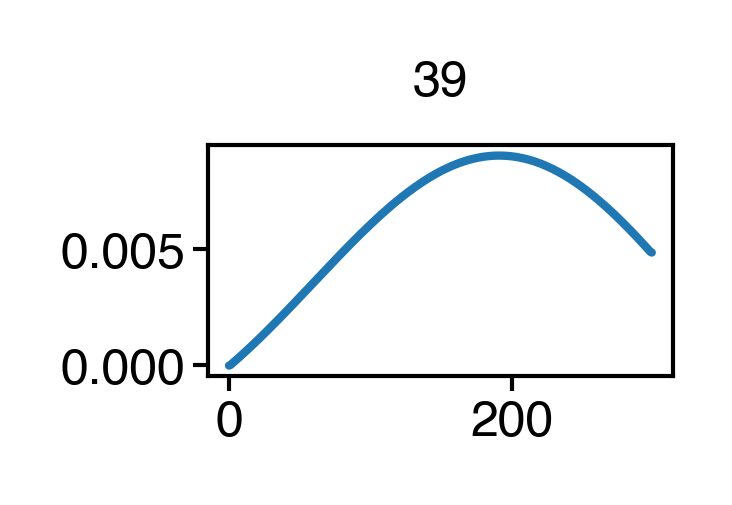

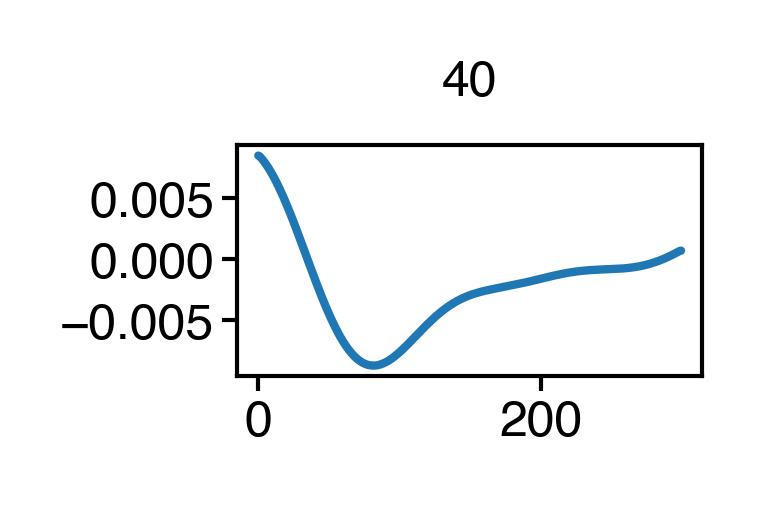

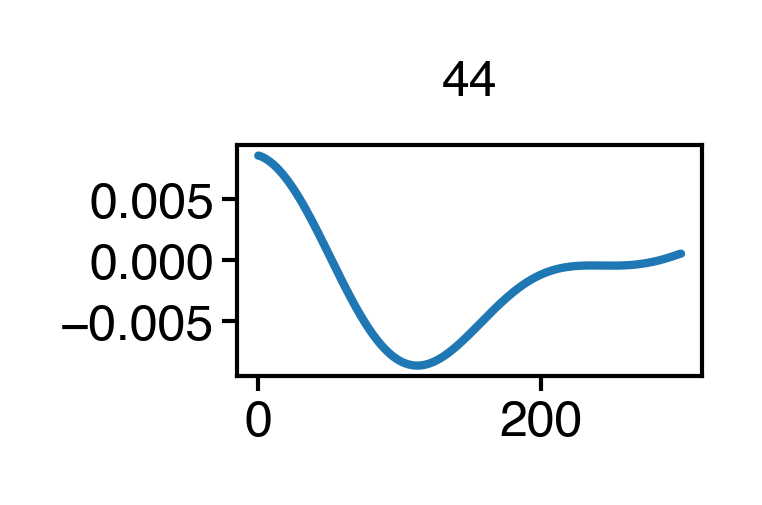

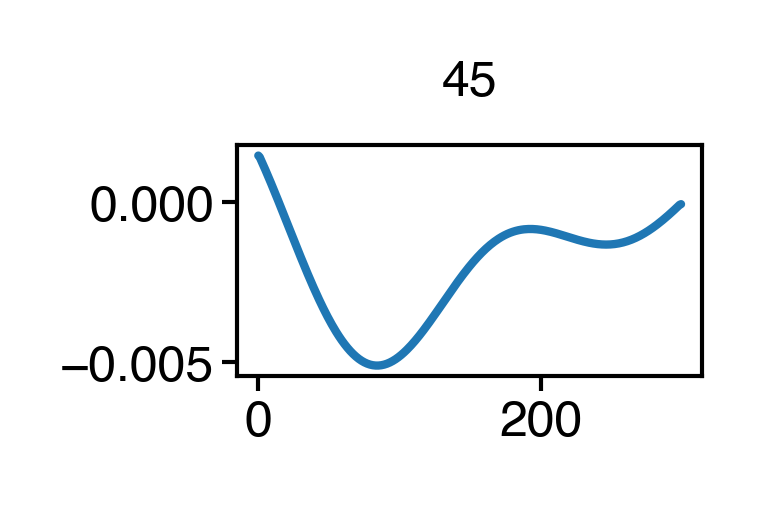

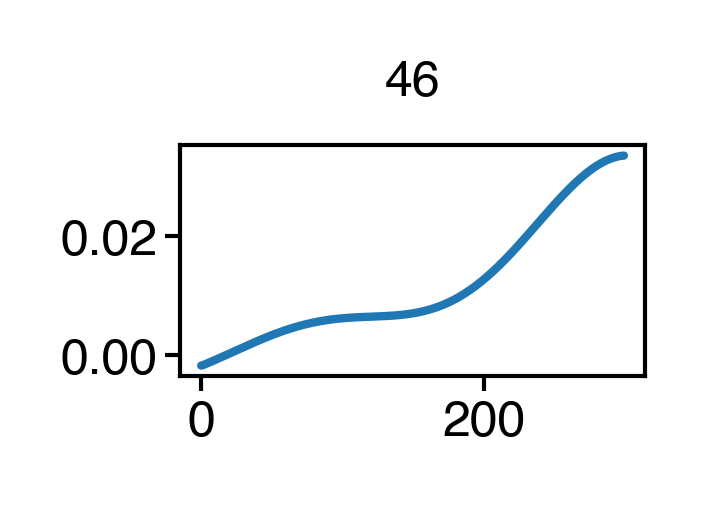

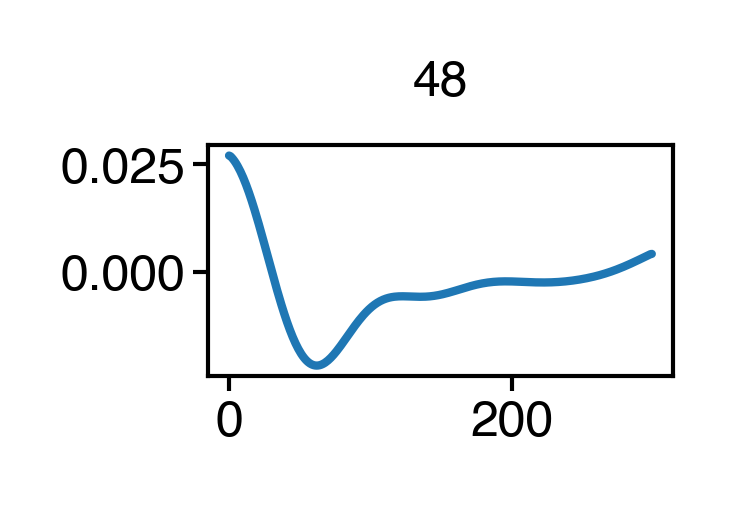

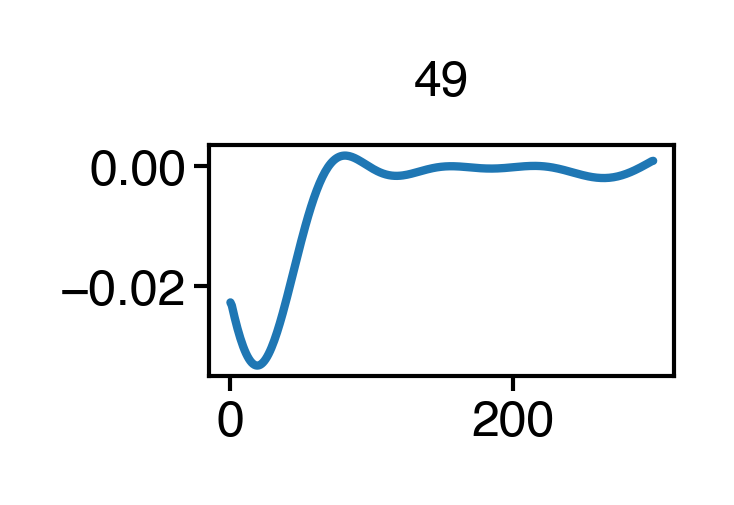

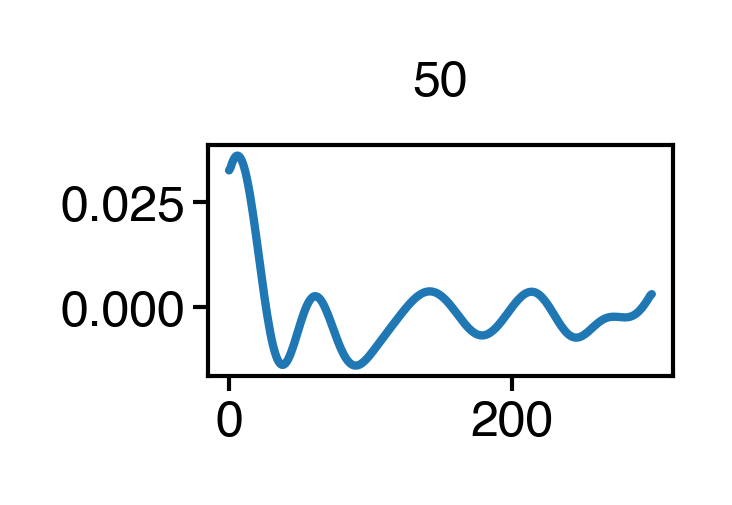

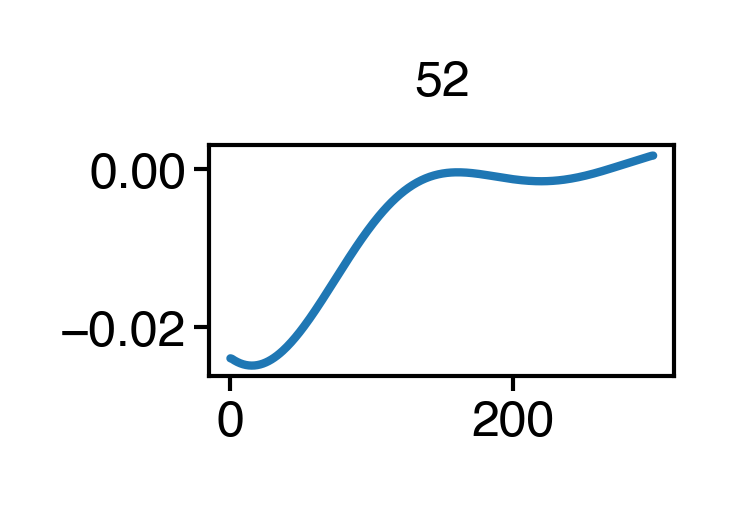

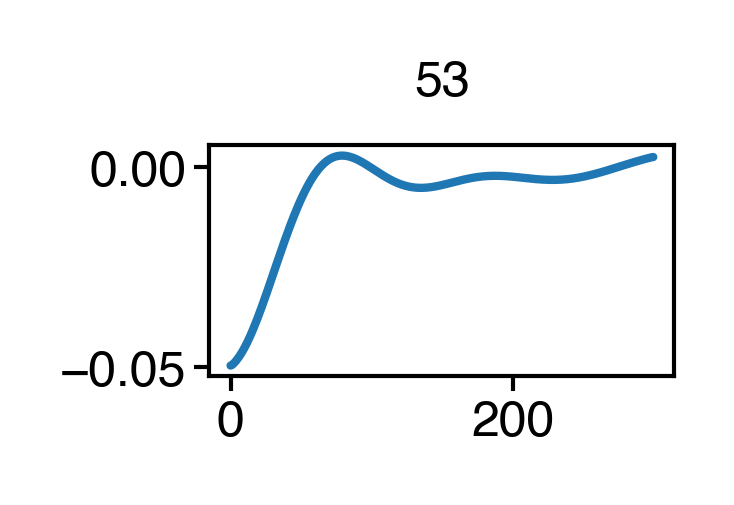

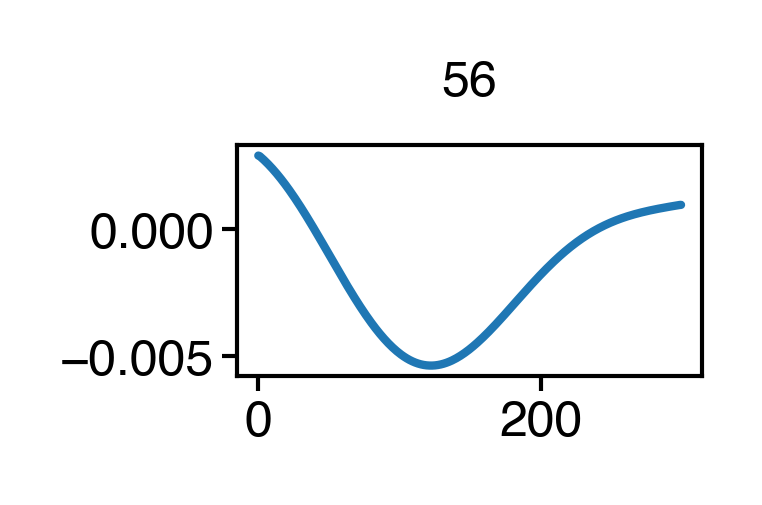

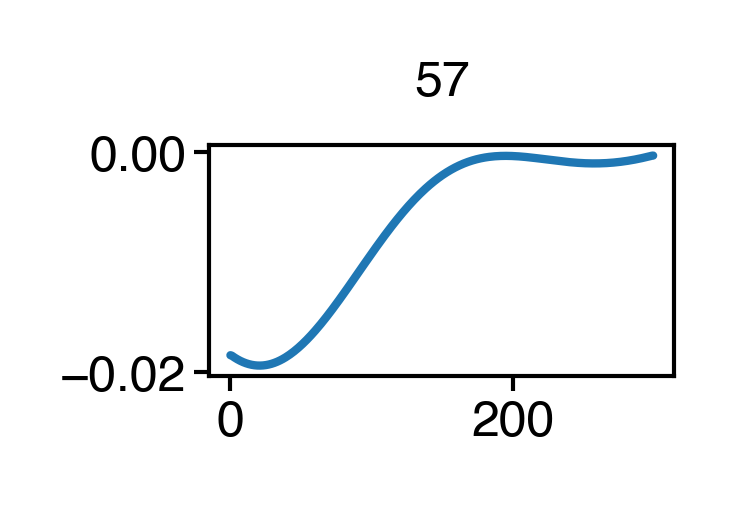

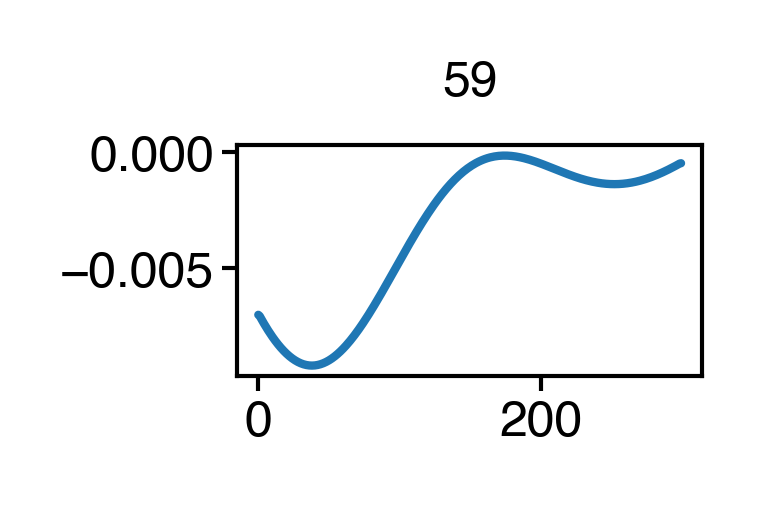

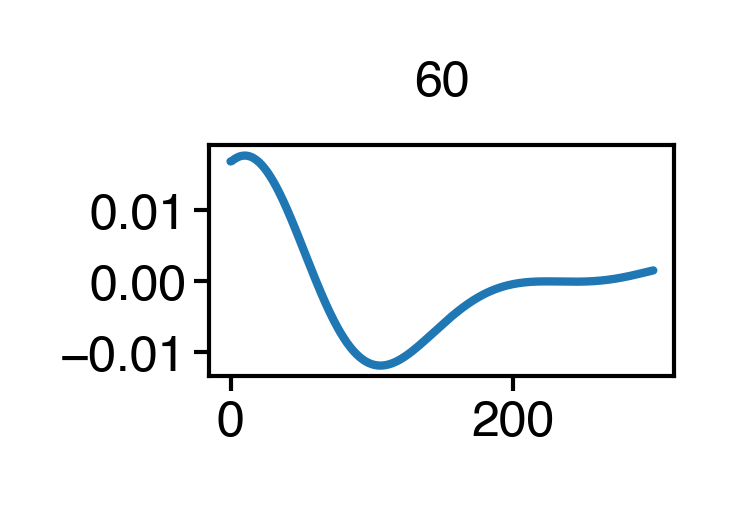

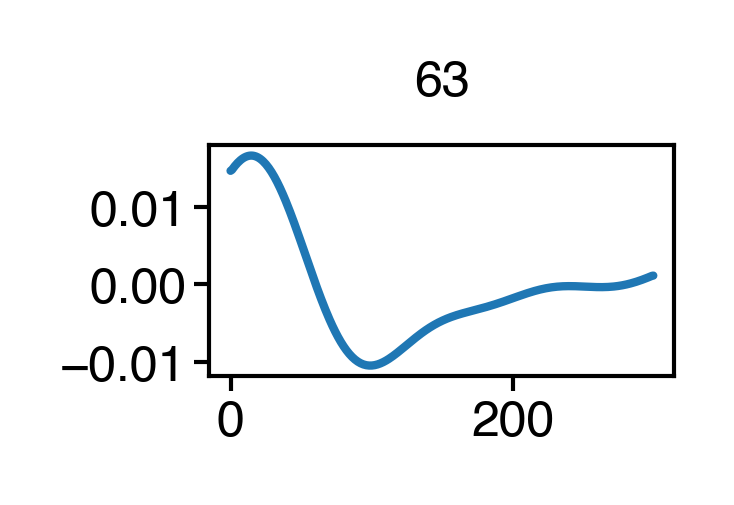

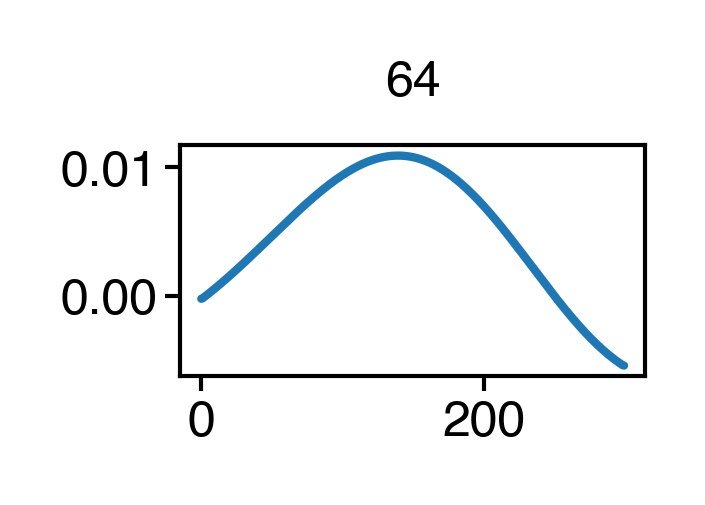

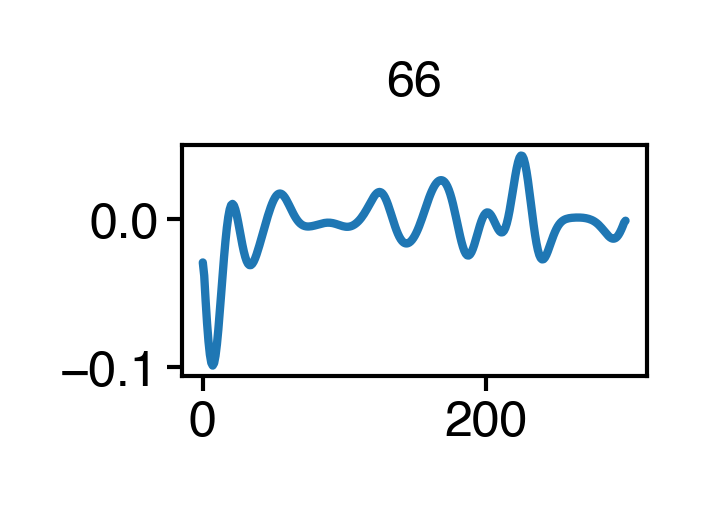

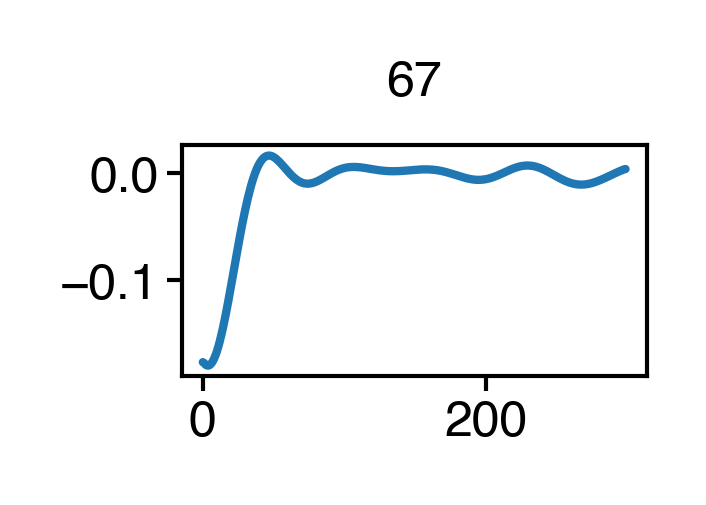

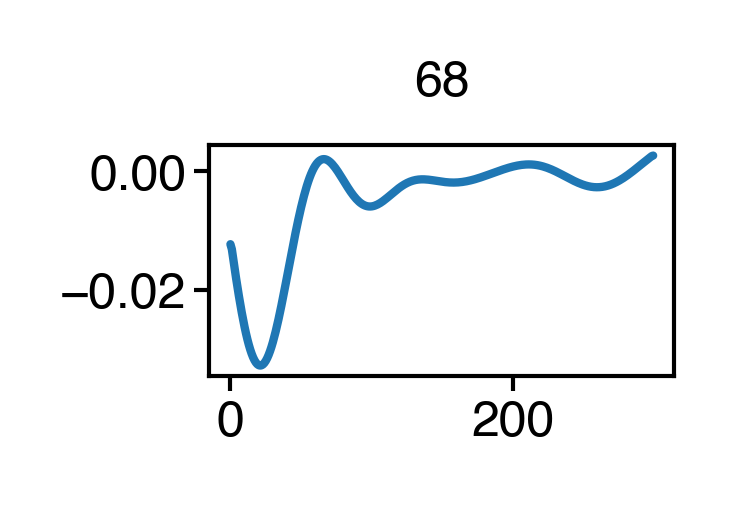

In [210]:
for k, v in keep_grads.items():
    figure(1, 0.5)
    plt.plot(v)
    plt.title(k)

In [25]:
grad_array = np.array(list(keep_grads.values()))

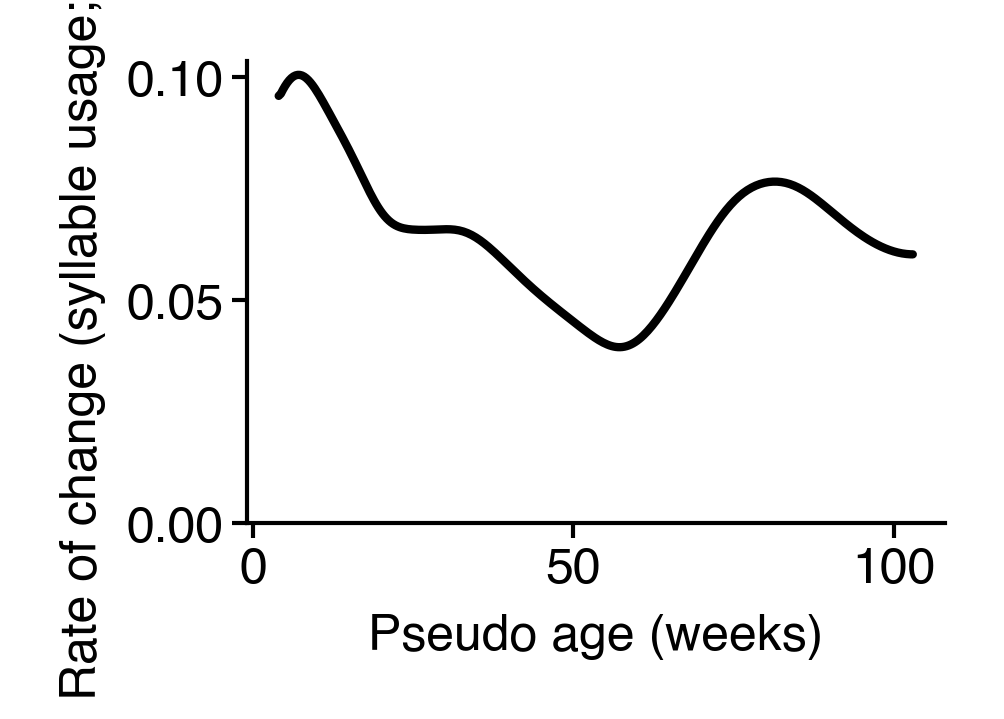

In [26]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time), np.linalg.norm(grad_array, axis=0), c='k')
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Pseudo age (weeks)')
plt.ylim(0, None)
sns.despine()
# saver(fig, "ontogeny-syllable-rate-of-change");

## Cluster syllable usage

In [221]:
from sklearn.cluster import KMeans

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 [65, 72, 46, 38, 49, 90, 57, 55, 36, 29, 81, 23, 92, 68, 59, 69]
Cluster 1 [47, 28, 42, 10, 30, 22, 56, 12, 41, 91, 98, 52, 7]
Cluster 2 [13, 86, 37, 15, 51, 77, 53, 27, 39, 58, 70, 95, 60, 21]
Cluster 3 [79, 25, 61, 63, 18, 84, 5, 43, 67, 74, 0, 19, 17, 35]
Cluster 4 [94, 6, 33, 82, 16, 96, 1, 80, 24, 78]


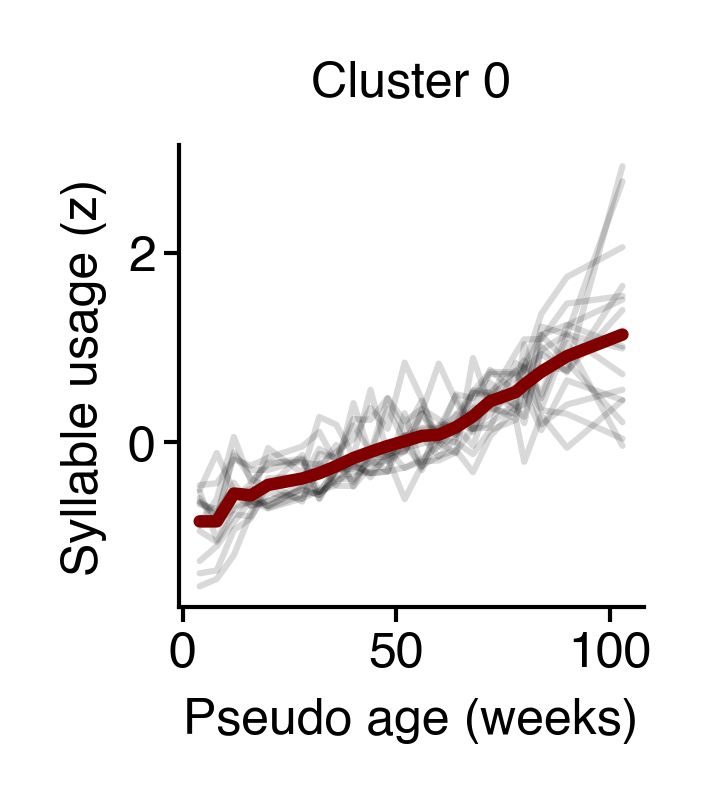

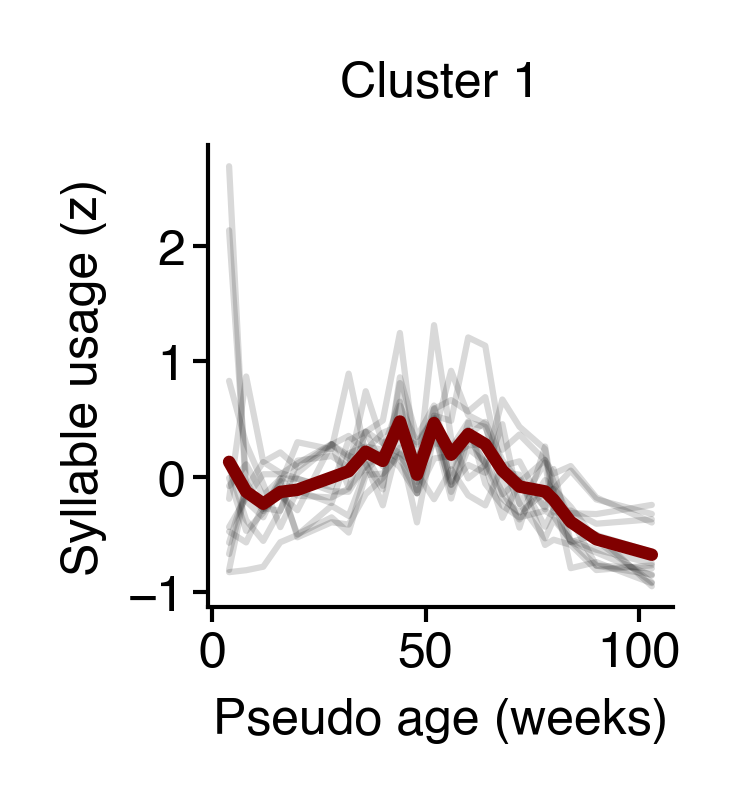

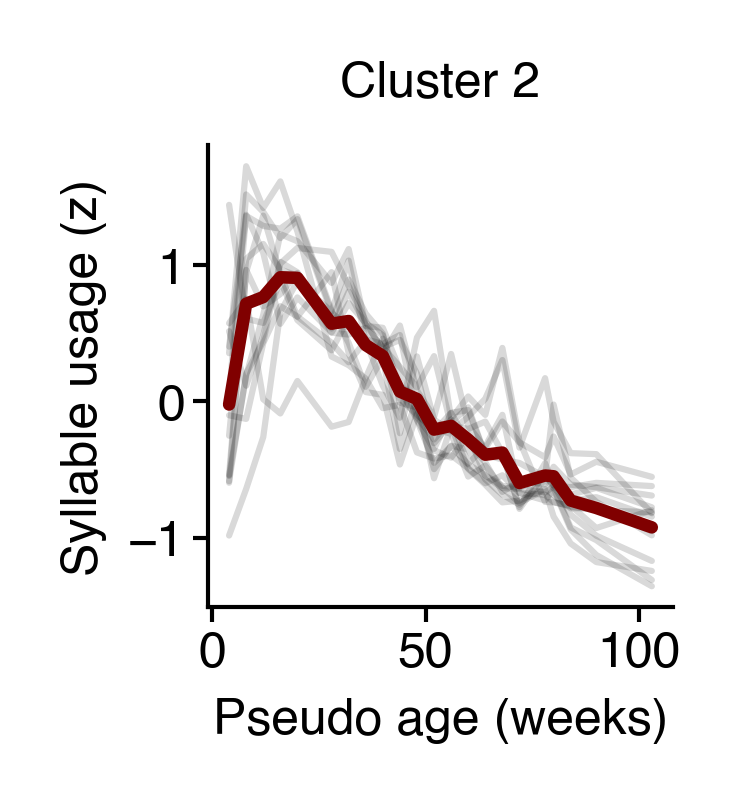

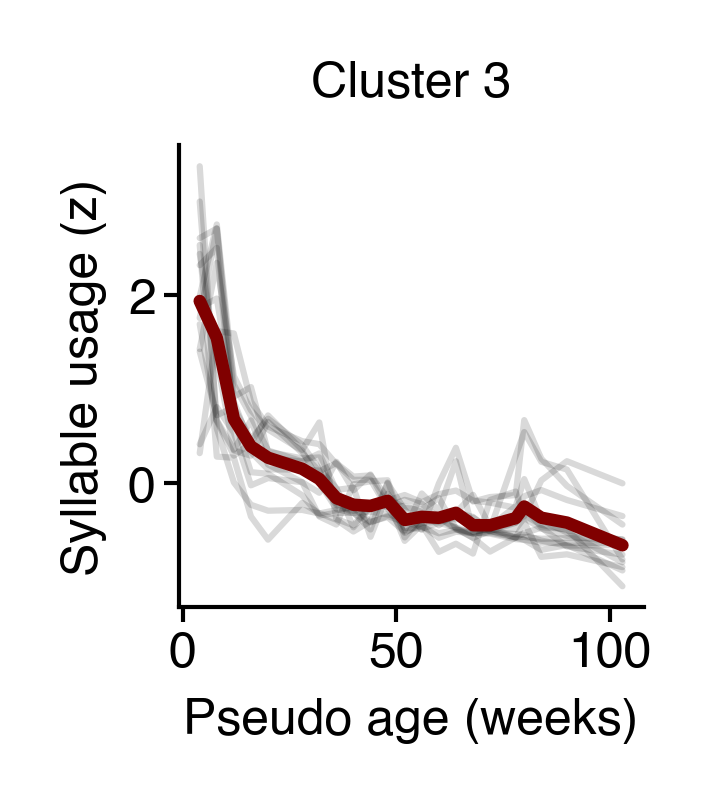

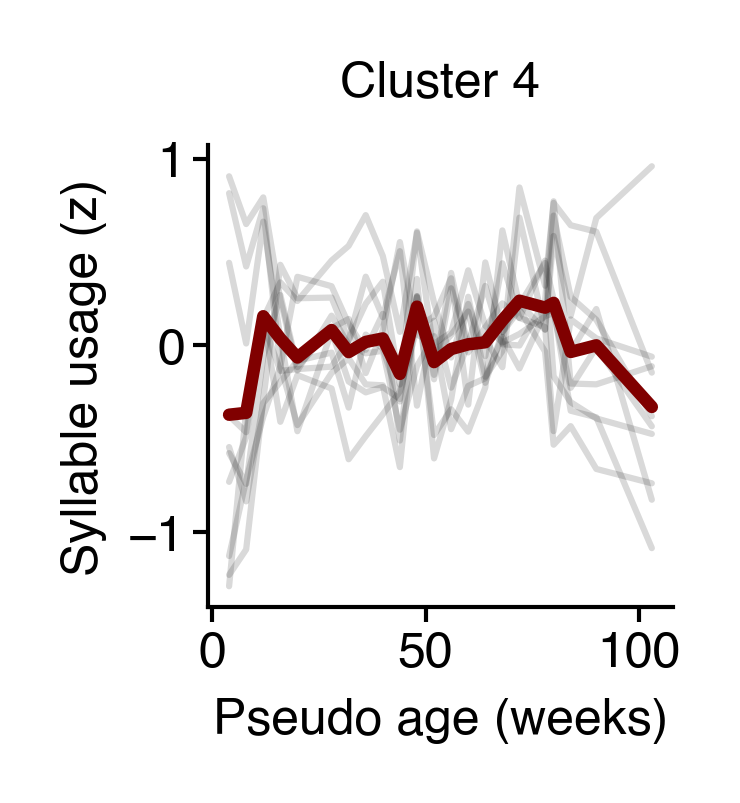

In [270]:
n_clusters = 5
clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(StandardScaler().fit_transform(merged_df[keep_sylls]).T)
scaled_df = pd.DataFrame(StandardScaler().fit_transform(merged_df[keep_sylls]), index=merged_df.index, columns=keep_sylls)
for i in range(n_clusters):
    fig = figure(1, 1)
    tmp = scaled_df.iloc[:, clusters == i].groupby('pseudo_age').mean()
    print(f'Cluster {i}', [reverse_map[x] for x in tmp.columns])
    plt.plot(tmp, c='k', lw=0.75, alpha=0.15)
    plt.plot(tmp.mean(1), c='maroon', lw=1.5)
    plt.title(f'Cluster {i}')
    plt.xlabel('Pseudo age (weeks)')
    plt.ylabel('Syllable usage (z)')
    sns.despine()
    saver(fig, f'ontogeny-syllable-cluster-{i}')

## Longtogeny age predictions

In [260]:
long_usages = pd.read_parquet("/n/groups/datta/win/longtogeny/data/ontogeny/version_08/longtogeny_males_clean_v1.parquet").fillna(0).astype('float32')
long_usages = long_usages[long_usages.index.get_level_values('age') < 600]

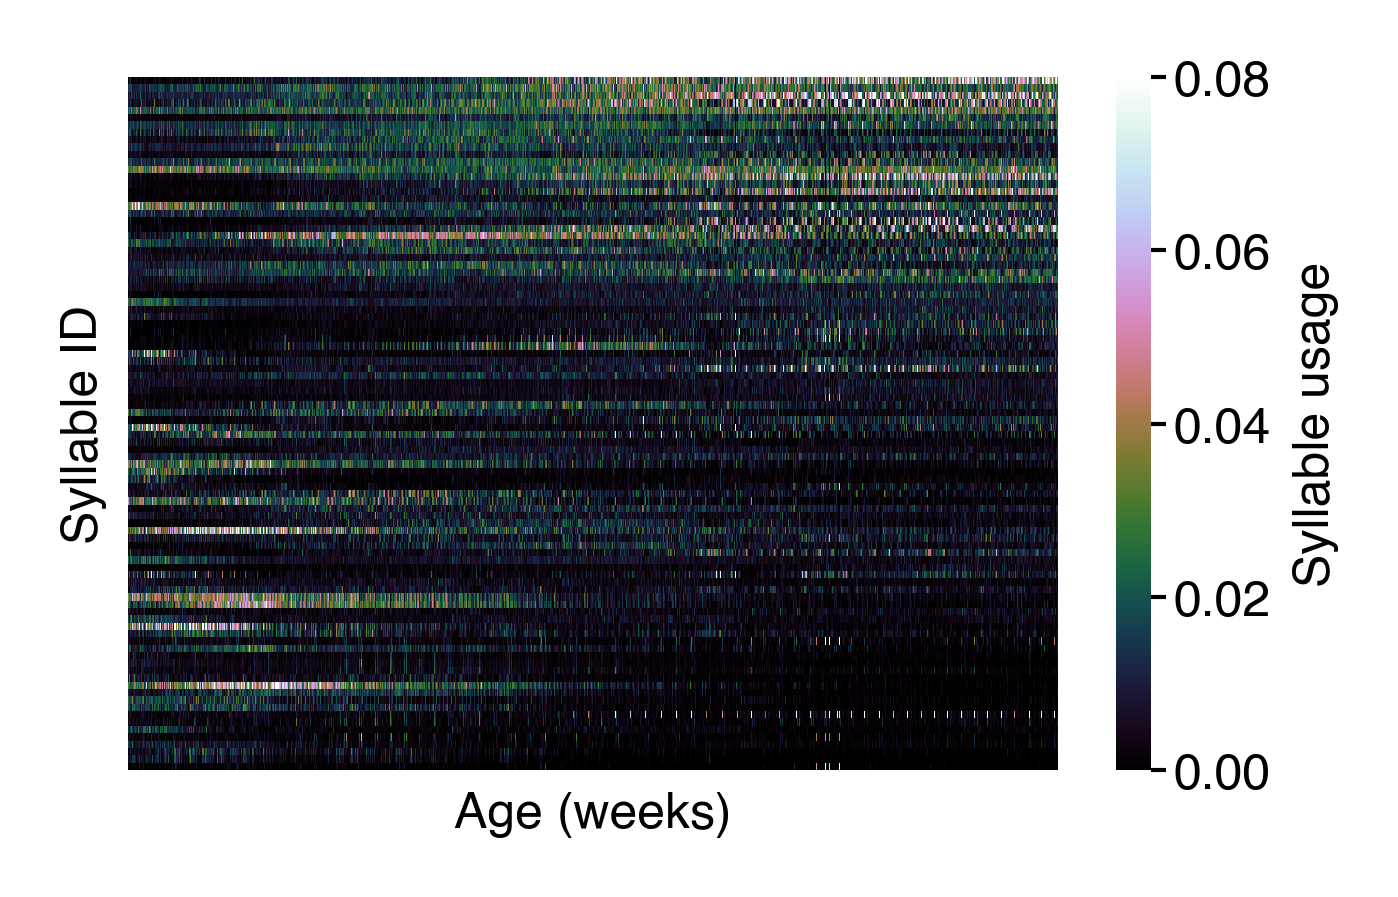

In [372]:
fig = figure(2.5, 1.5)
ax = sns.heatmap(long_usages.T, cmap="cubehelix", cbar_kws={'label': 'Syllable usage'}, vmax=0.08)
ax.set(xlabel='Age (weeks)', ylabel='Syllable ID', xticks=[], yticks=[])
saver(fig, 'longtogeny-syllable-usage-heatmap');

In [262]:
kernel = 1 * RBF(length_scale=5e2, length_scale_bounds=(1e-4, 1e3))

out = {}

for mouse, _df in tqdm(long_usages.groupby("mouse")):
    x = _df.index.get_level_values("age") / 7
    mouse_preds = {}
    for syll in keep_sylls:
        y = _df[syll]
        gp = GaussianProcessRegressor(
            kernel=kernel, n_restarts_optimizer=10, alpha=0.55, normalize_y=True
        )
        gp.fit(x.to_numpy().reshape(-1, 1), y)
        mouse_preds[syll] = pd.Series(gp.predict(x.to_numpy().reshape(-1, 1)), index=x)
    out[mouse] = mouse_preds

  0%|          | 0/16 [00:00<?, ?it/s]

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [271]:
pseudo_y = merged_df.index.get_level_values('pseudo_age')
x = merged_df[keep_sylls]
mdl = cv.best_estimator_.fit(x, pseudo_y)

In [272]:
mouse_df_dict = valmap(pd.DataFrame, out)
mouse_pred_dict = valmap(lambda v: pd.Series(mdl.predict(v), index=v.index), mouse_df_dict)

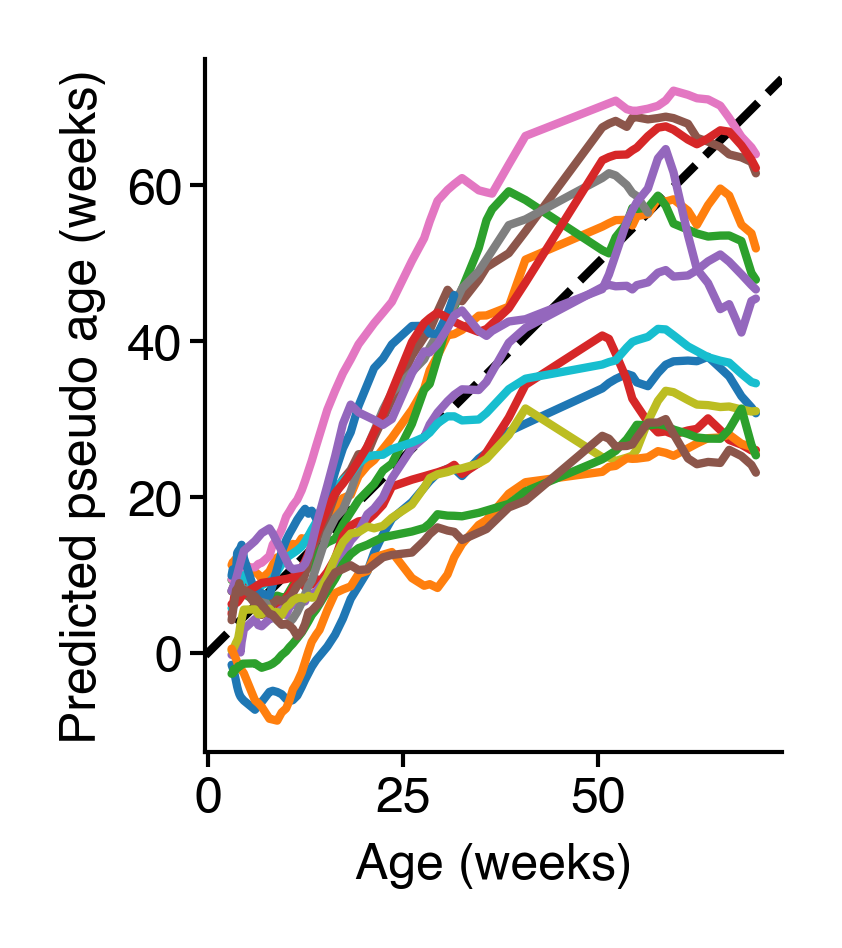

In [373]:
fig = figure(1.5, 1.5)
for k, v in mouse_pred_dict.items():
    plt.plot(v)
ax = plt.gca()
add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlabel="Age (weeks)", ylabel="Predicted pseudo age (weeks)", aspect='equal')
sns.despine()
saver(fig, 'longtogeny-pseudo-age-regression');

In [283]:
oldest_age = pd.DataFrame(mouse_pred_dict).iloc[-1].sort_values().dropna()

In [287]:
youngins = oldest_age.iloc[:len(oldest_age)//2]

In [288]:
oldies = oldest_age.iloc[len(oldest_age)//2:]

In [297]:
age_cut = pd.qcut(long_usages.index.get_level_values('age'), 15, labels=False)

In [298]:
long_usages['age_cut'] = age_cut
long_usages.set_index('age_cut', append=True, inplace=True)

In [290]:
def get_mice(df, mouse_id_arr):
    mask = df.index.get_level_values('mouse').isin(mouse_id_arr)
    return df[mask]


In [300]:
youngins_df = get_mice(long_usages, youngins.index)
oldies_df = get_mice(long_usages, oldies.index)

In [303]:
youngins_df = youngins_df.groupby(['age_cut', 'mouse']).mean()
oldies_df = oldies_df.groupby(['age_cut', 'mouse']).mean()

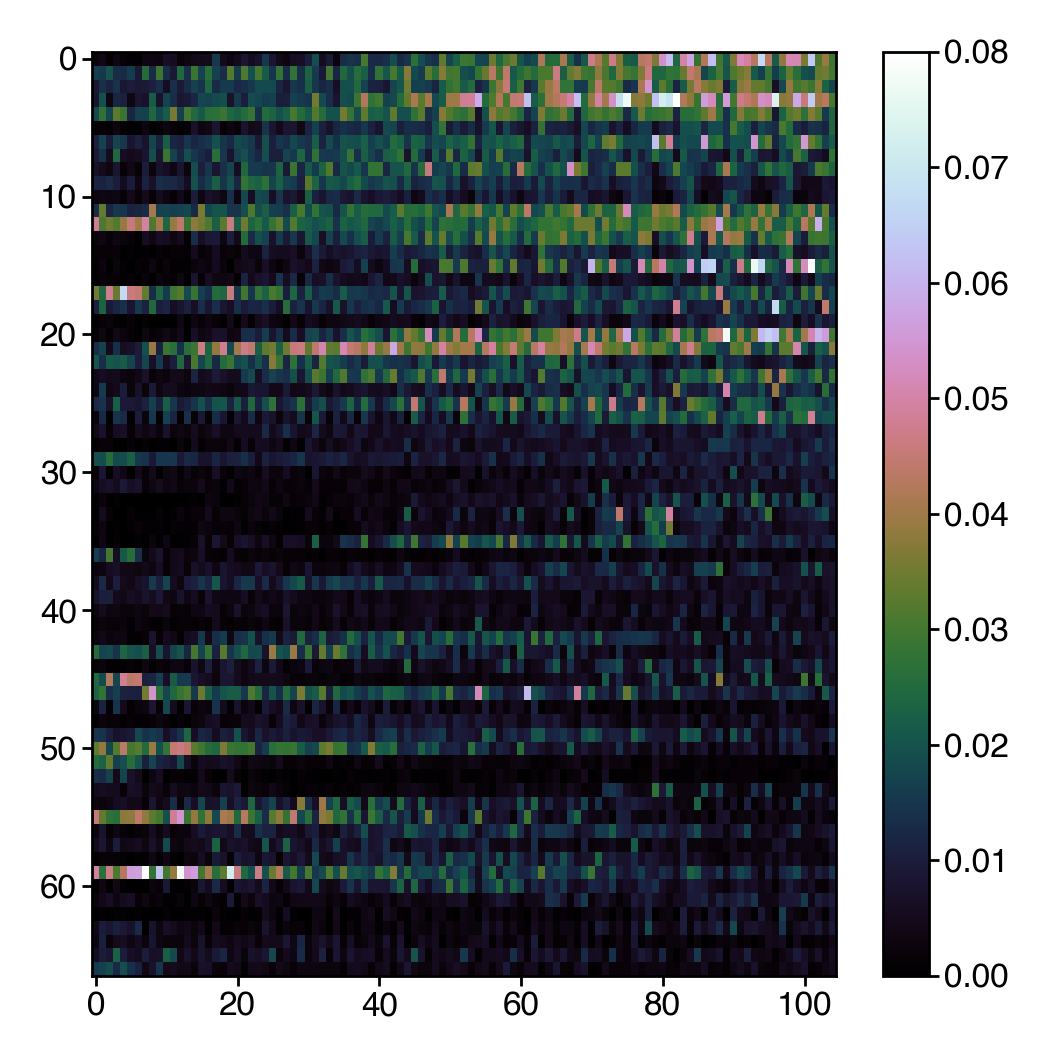

In [305]:
plt.imshow(youngins_df[keep_sylls].T, aspect='auto', cmap='cubehelix', vmin=0, vmax=0.08, interpolation='none')
plt.colorbar()

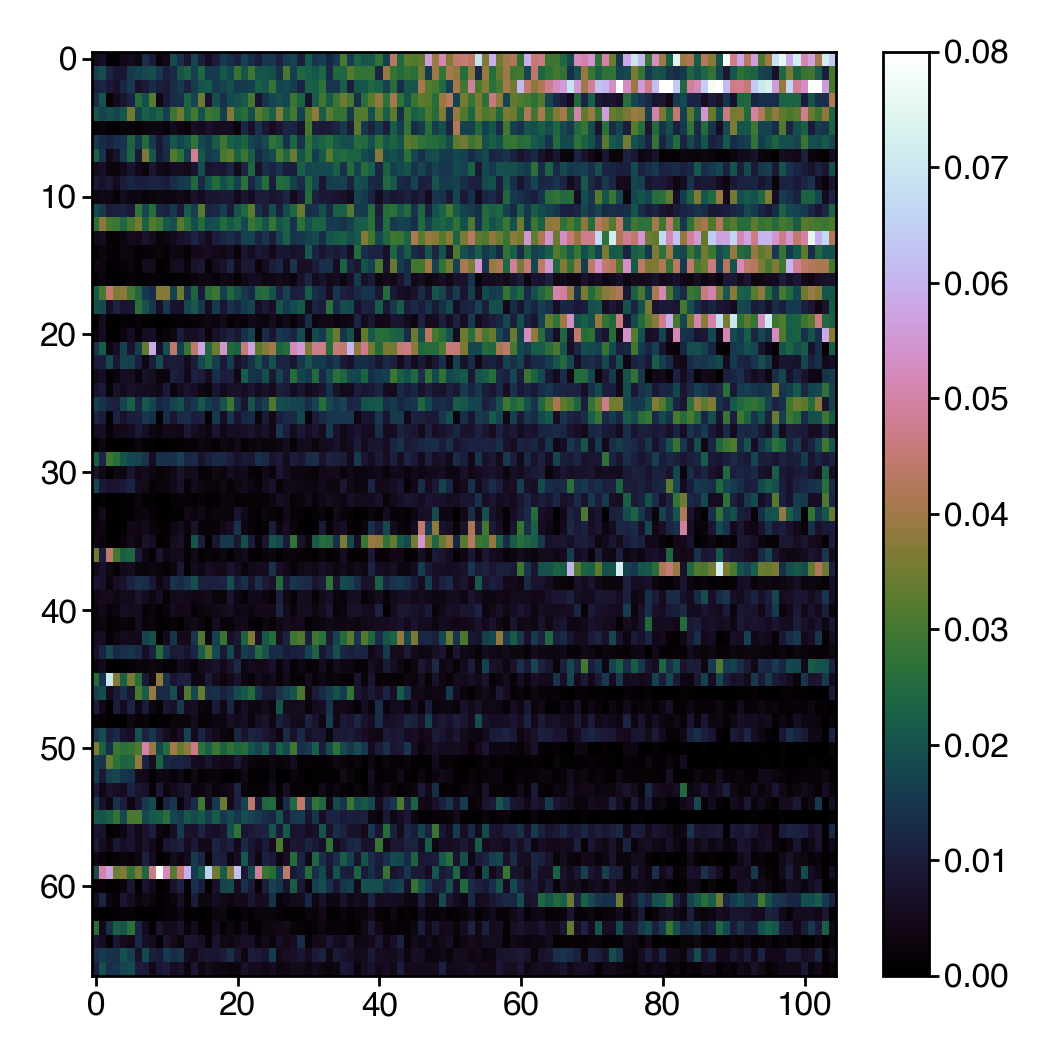

In [306]:
plt.imshow(oldies_df[keep_sylls].T, aspect='auto', cmap='cubehelix', vmin=0, vmax=0.08, interpolation='none')
plt.colorbar()

In [308]:
mask = youngins_df.index.get_level_values('age_cut') > 12
c1 = youngins_df.loc[mask, keep_sylls]
mask = oldies_df.index.get_level_values('age_cut') > 12
c2 = oldies_df.loc[mask, keep_sylls]
combined = pd.concat([c1, c2])
classes = np.array([0] * len(c1) + [1] * len(c2))

In [345]:
from sklearn.linear_model import LogisticRegression

In [362]:
logistic = LogisticRegression()
logistic.fit(combined, classes)  # train it

LogisticRegression()

In [363]:
most_different = keep_sylls[np.argsort(np.abs(logistic.coef_.squeeze()))[::-1]]

In [364]:
youngin_avgs = youngins_df[keep_sylls].groupby('age_cut').mean()
oldies_avgs = oldies_df[keep_sylls].groupby('age_cut').mean()

In [365]:
ages = long_usages.index.get_level_values('age').groupby(long_usages.index.get_level_values('age_cut'))
ages = list(valmap(lambda v: np.mean(v) / 7, ages).values())

0 2 72
1 13 38
2 3 94
3 19 55
4 20 16
5 39 92
6 23 51
7 21 15
8 0 65
9 11 37


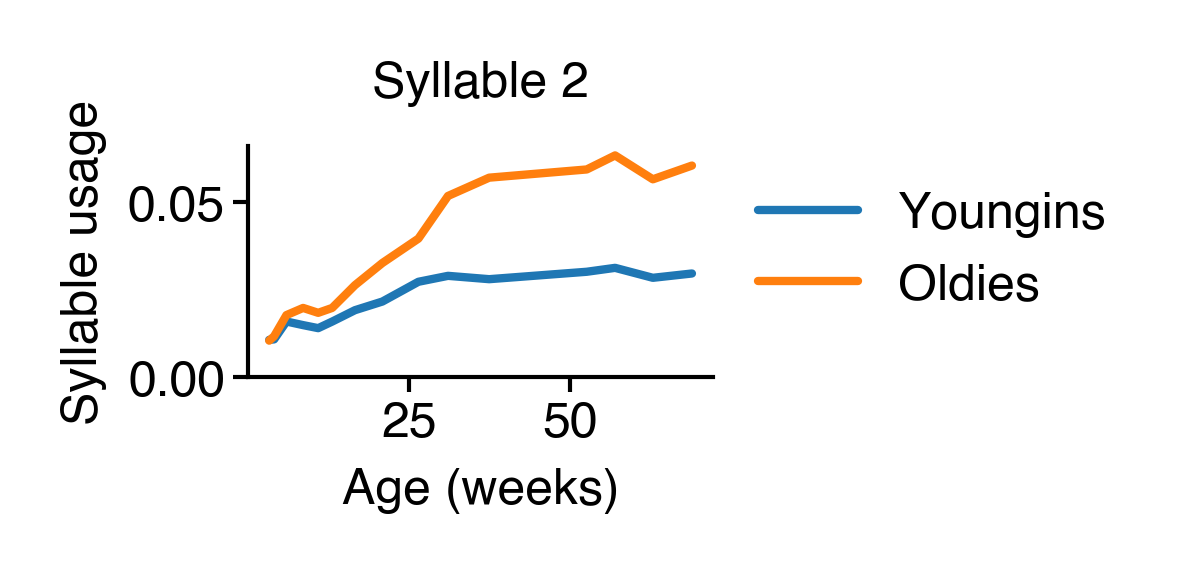

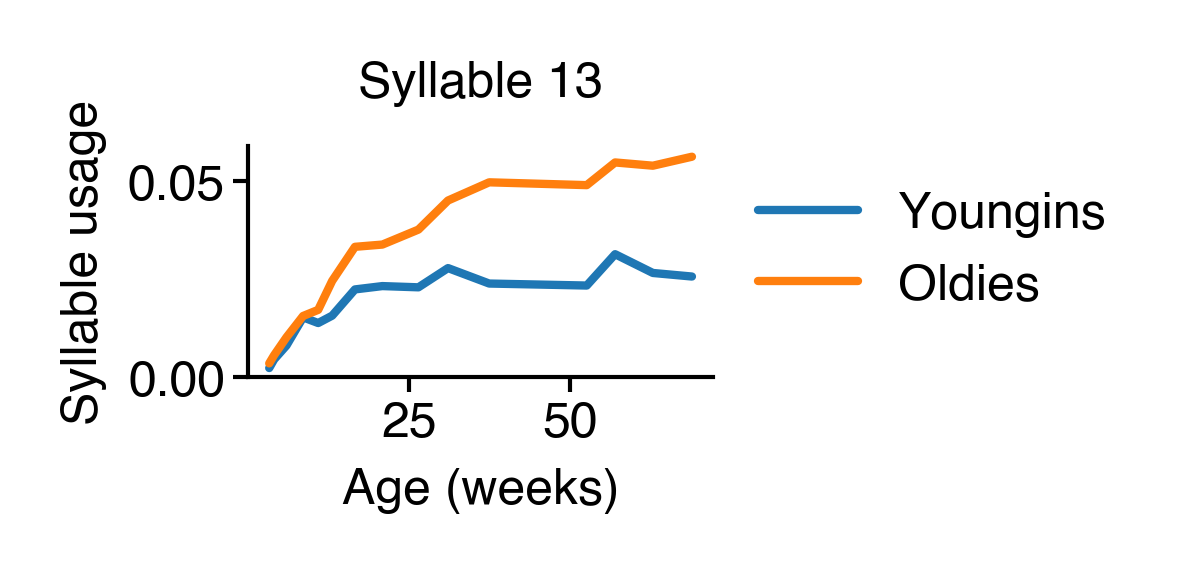

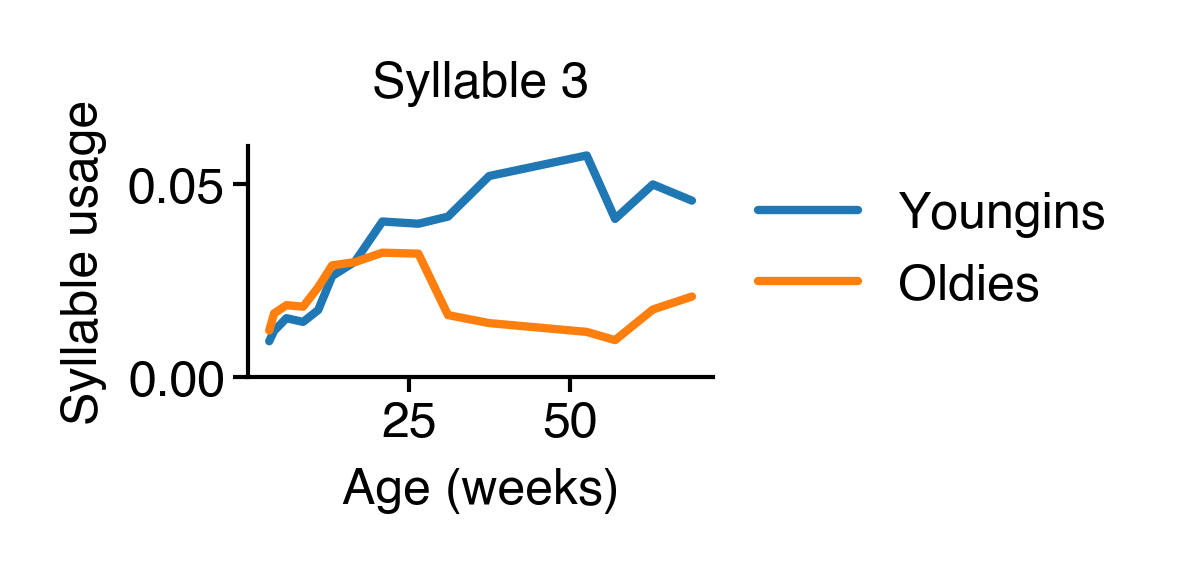

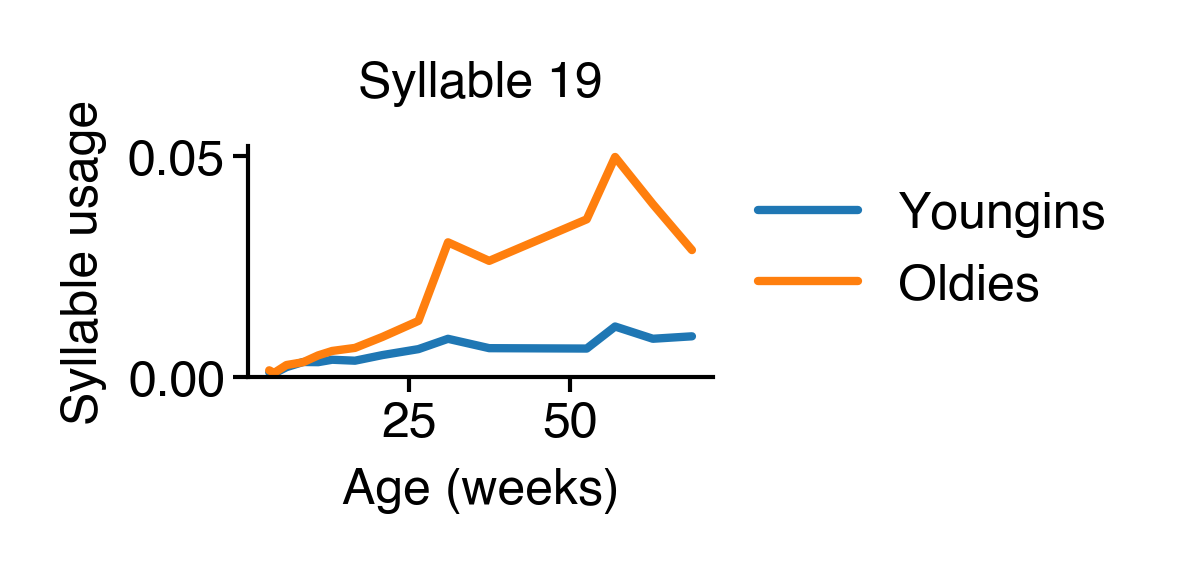

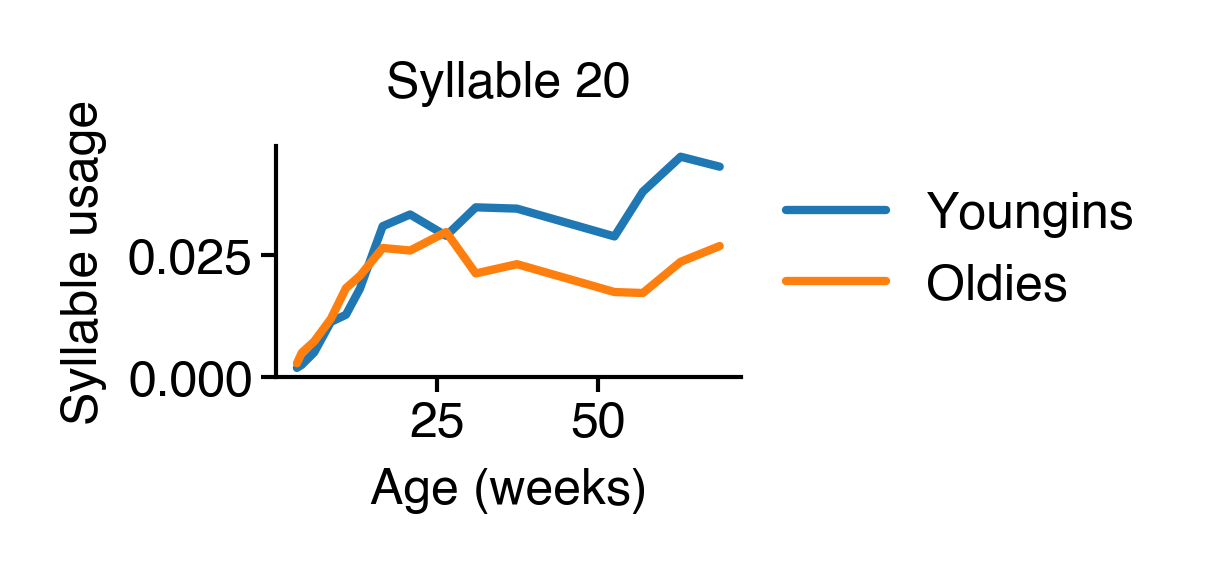

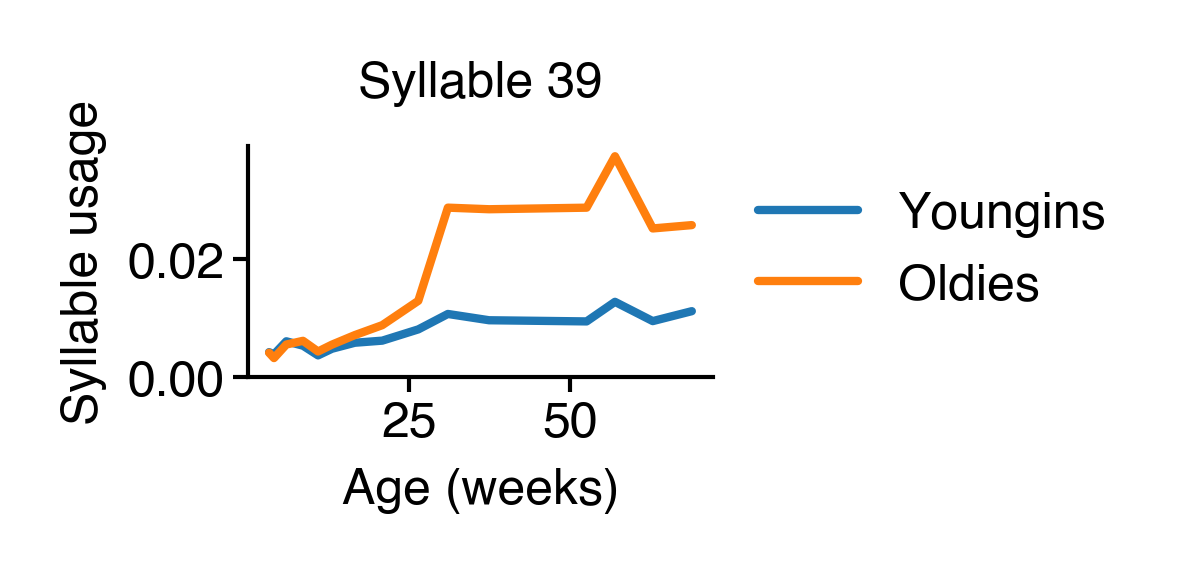

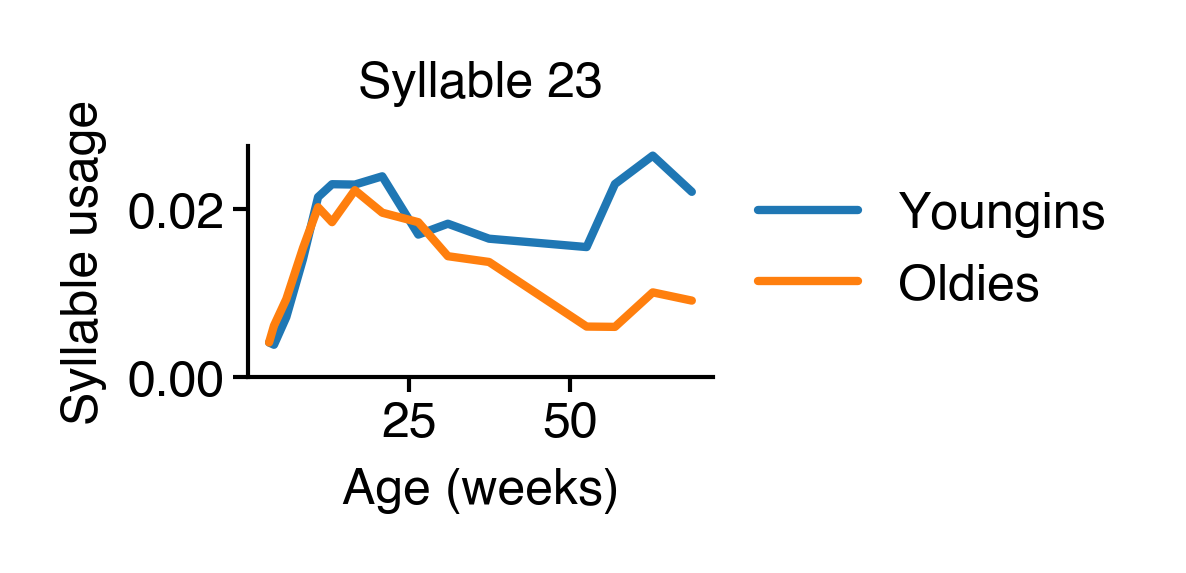

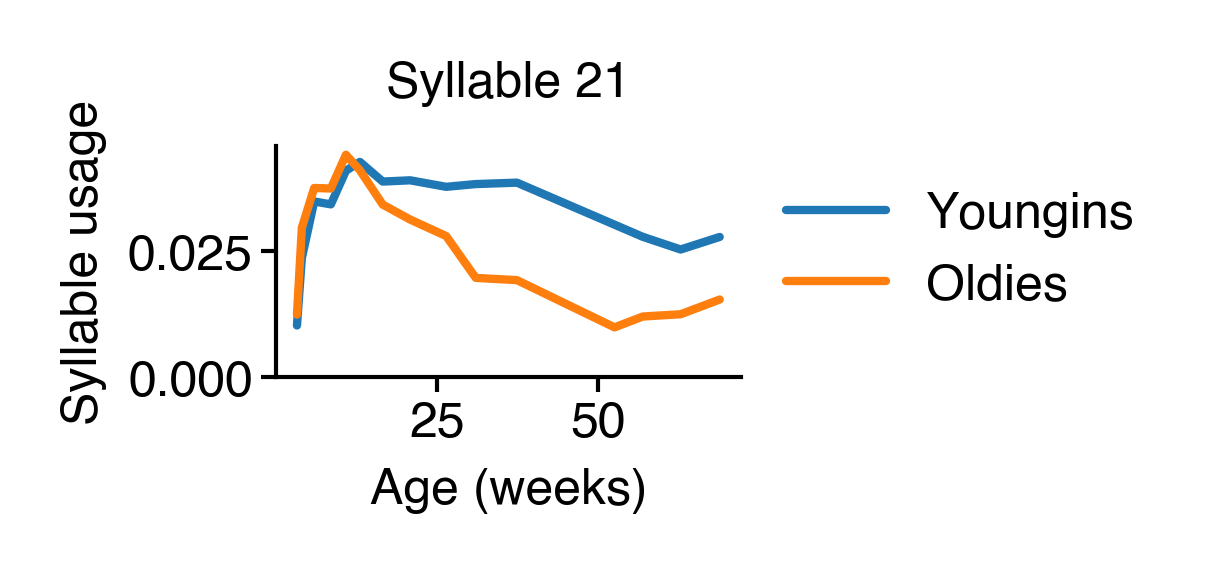

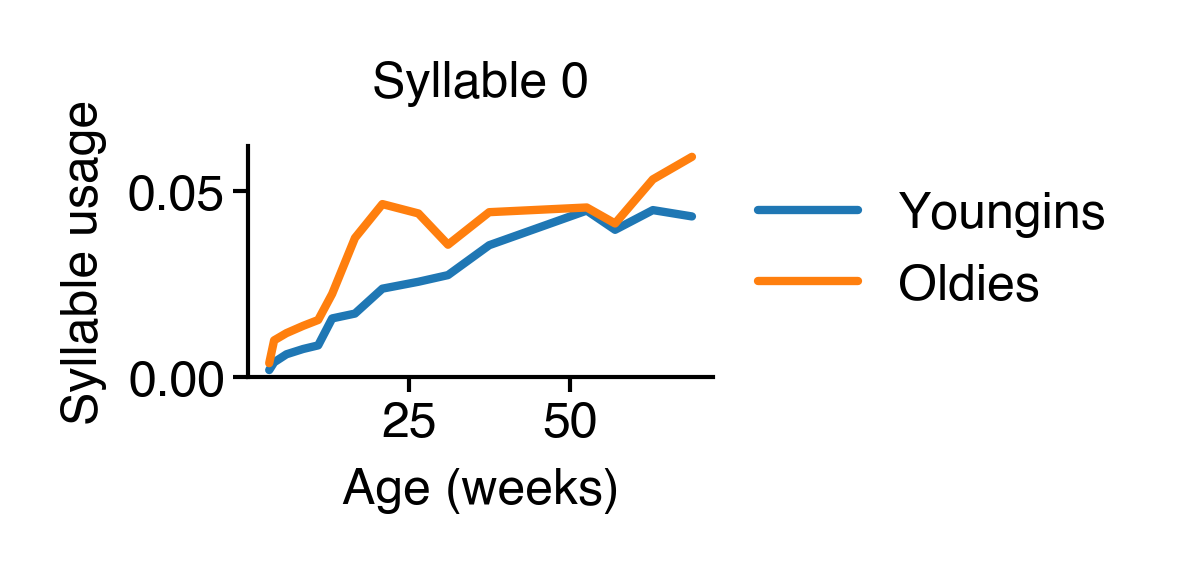

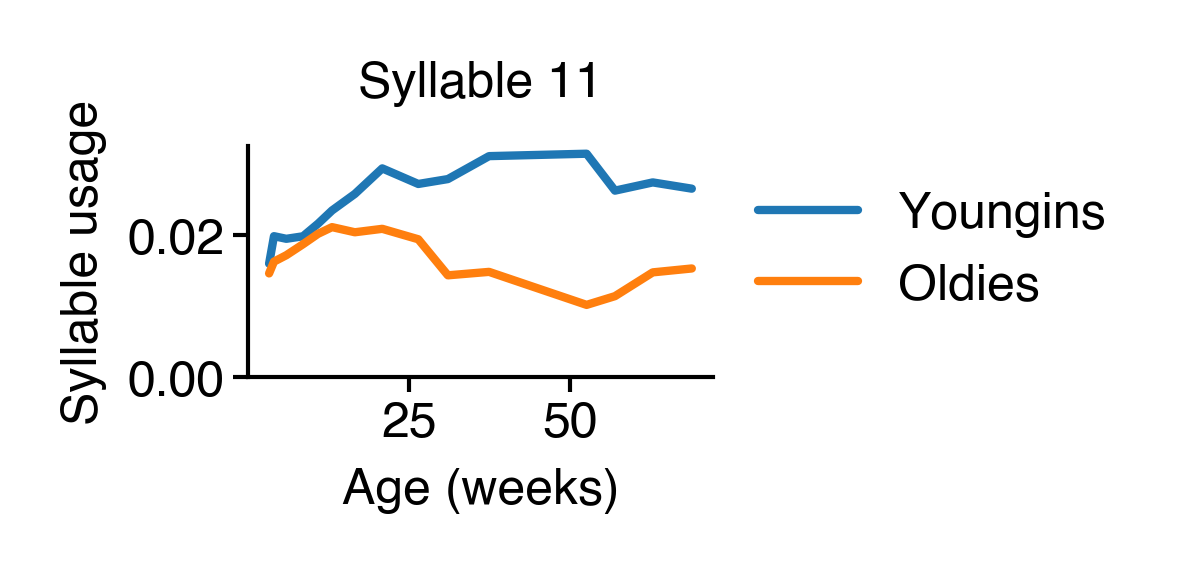

In [367]:
for i, syll in enumerate(range(10)):
    fig = figure(1, 0.5)
    plt.plot(ages, youngin_avgs[most_different[syll]].to_numpy(), label='Youngins')
    plt.plot(ages, oldies_avgs[most_different[syll]].to_numpy(), label='Oldies')
    plt.ylim(0)
    plt.xlabel('Age (weeks)')
    plt.ylabel('Syllable usage')
    plt.title(f'Syllable {most_different[syll]}')
    print(i, most_different[syll], reverse_map[most_different[syll]])
    legend()
    sns.despine()
    saver(fig, f"syll-{i}-youngin-vs-oldie-difference")

## Klothos

In [374]:
def load_klothos_df():
    df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_08/klothos_syllable_df_v00.parquet')
    df['relabeled_syllables'] = df['syllables'].map(umap)
    usages = df.query('onsets').groupby(['subject_name', 'date'])['relabeled_syllables'].value_counts(normalize=True)
    usage_mtx = pd.pivot_table(usages.reset_index(), index=['subject_name', 'date'], columns='relabeled_syllables', values='proportion', fill_value=0)
    return usage_mtx

In [375]:
klothos_mtx = load_klothos_df()

In [378]:
klothos_age_pred = mdl.predict(klothos_mtx.reindex(columns=keep_sylls, fill_value=0))
klothos_age_pred = pd.Series(klothos_age_pred, index=klothos_mtx.index, name='predicted_age').reset_index()

In [387]:
klothos_age_pred.head()

subject_name                date  predicted_age treatment_day exp_type
0   K90M_01_01 2023-12-05 15:33:09      30.332237        before   saline
1   K90M_01_01 2023-12-06 15:26:40      36.699433         after   saline
2   K90M_01_02 2023-12-05 12:33:28      20.668588        before   saline
3   K90M_01_02 2023-12-06 12:28:27      21.878442         after   saline
4   K90M_01_03 2023-12-05 15:33:42      25.138940        before   saline

In [381]:
exp_type = []
inj_type = []
for idx, row in klothos_age_pred.iterrows():
    masks = klothos_age_pred.loc[klothos_age_pred['subject_name'] == row.subject_name]
    masks.drop(index=idx)
    if masks['date'].iloc[0] < row.date:
        exp_type.append('after')
    else:
        exp_type.append('before')
    if int(row.subject_name.split('_')[1]) in [2, 4]:
        inj_type.append('klothos')
    else:
        inj_type.append('saline')

In [382]:
klothos_age_pred['treatment_day'] = exp_type
klothos_age_pred['exp_type'] = inj_type

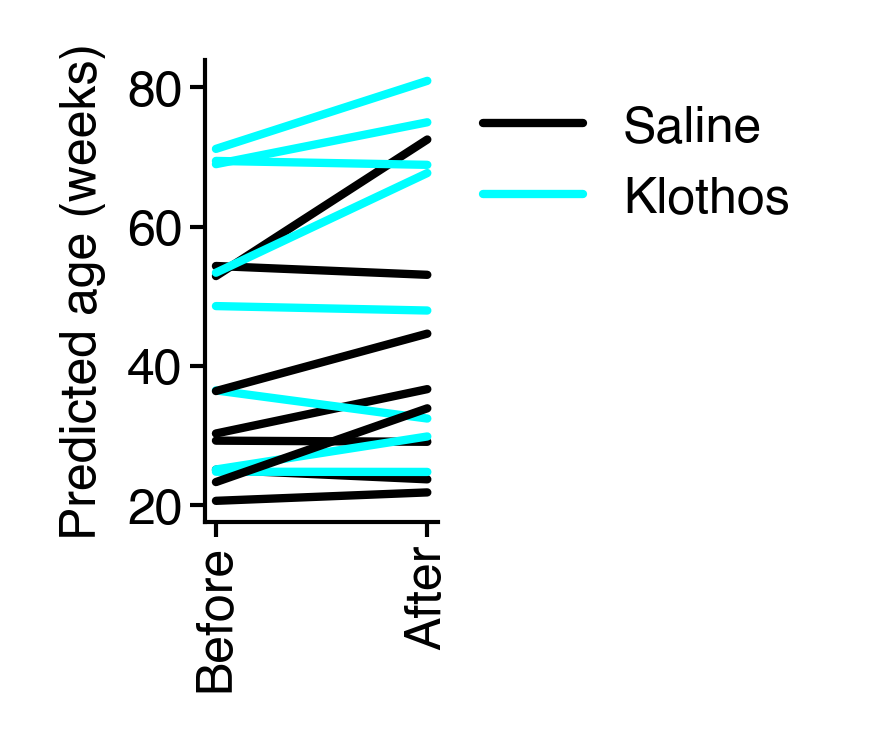

In [434]:
fig = figure(0.5, 1)
saline_flag = False
exp_flag = False
for animal, _df in klothos_age_pred.groupby('subject_name'):
    is_saline = _df.iloc[0]['exp_type'] == 'saline'
    if is_saline:
        if not saline_flag:
            plt.plot([0, 1], _df['predicted_age'], c='k', label='Saline')
            saline_flag = True
        else:
            plt.plot([0, 1], _df['predicted_age'], c='k')
    else:
        if not exp_flag:
            plt.plot([0, 1], _df['predicted_age'], c='cyan', label='Klothos')
            exp_flag = True
        else:
            plt.plot([0, 1], _df['predicted_age'], c='cyan')
ax = plt.gca()
ax.set(ylabel="Predicted age (weeks)", xticks=[0, 1], xticklabels=['Before', 'After'])
plt.xticks(rotation=90)
legend()
sns.despine()
saver(fig, "klothos-predicted-age");

In [398]:
diffs = klothos_age_pred.groupby(["subject_name", "exp_type"])['predicted_age'].diff().dropna()
idx = klothos_age_pred.groupby(["subject_name", "exp_type"])['predicted_age'].count().index
diffs.index = idx

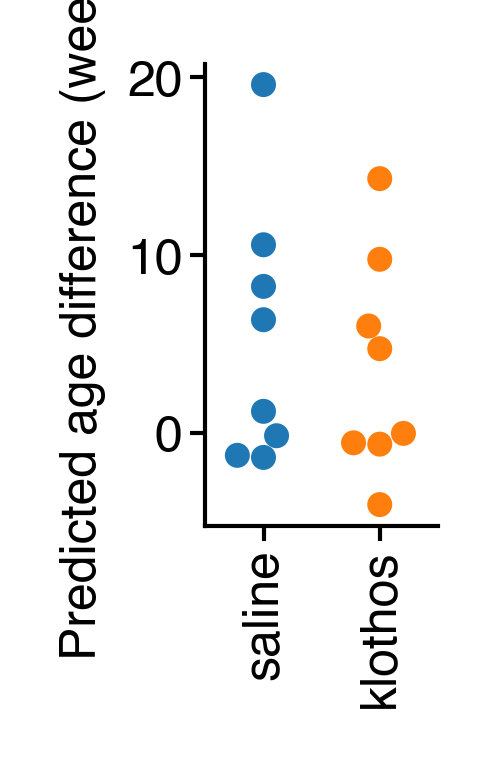

In [425]:
fig = figure(0.5, 1)
ax = sns.swarmplot(data=diffs.reset_index(), x='exp_type', y='predicted_age', hue='exp_type', size=3)
plt.xticks(rotation=90)
ax.set(xlabel='', ylabel='Predicted age difference (weeks)')
sns.despine()
saver(fig, 'klothos-predicted-age-difference');

In [426]:
from scipy.stats import ttest_ind

In [429]:
diffs = diffs.reorder_levels(['exp_type', 'subject_name'])

In [432]:
ttest_ind(diffs.loc['saline'], diffs.loc['klothos'], alternative='greater')

TtestResult(statistic=0.5029548344849599, pvalue=0.3114077351983696, df=14.0)